# Khởi tạo hàm và các biến

In [ ]:
import torch
import numpy as np
import seaborn as sns
import time as t
import PIL.Image as Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda, Resize, ToPILImage
from matplotlib import pyplot as plt
from google.colab import drive
from ignite.metrics import InceptionScore
drive.mount('/content/drive')
print('drive mounted')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive mounted


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(20020711) 
randim = torch.empty([9,256,1,1]).normal_().to(device) 

Using cuda device


In [ ]:
im_reshape = lambda y,z: torch.hstack([y[0].reshape((-1,1)),y[1].reshape((-1,1)),y[2].reshape((-1,1))]).reshape(z,z,3).numpy()
de_scale = lambda y: (y+1)/2
def w_loss_dis(fake,real):
    return torch.mean(fake), torch.mean(real)
def w_loss_gen(data):
    return torch.mean(data)
def get_grad_norm(output,data,epsilon):
    gradients = torch.autograd.grad(outputs=output, inputs=data, grad_outputs=torch.ones(output.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
    return (((gradients.view(gradients.size()[0], -1).norm(2, 1) - epsilon) ** 2)/(epsilon**2)).mean()
def init_state():
    generator_history = {}
    generator_history['generator_loss'] = []
    generator_history['discriminator_mean_score_on_fake']=[]

    discriminator_history = {}
    discriminator_history['discriminator_loss']=[]
    discriminator_history['gradient norm']=[]
    discriminator_history['sum_discriminator_loss']=[]
    discriminator_history['discriminator_mean_score_on_both']=[]

    Incep_Score = []
    return generator_history,discriminator_history,Incep_Score
def save_model(size):
    torch.save({
            'epochs':epochs,    
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': gen_optimizer.state_dict(),
            'loss': generator_history,
            'IS': Incep_Score,
            }, '/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/'+str(size)+'x'+str(size)+'_pgen_mnbstd')
    torch.save({
            'epochs':epochs,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': dis_optimizer.state_dict(),
            'loss': discriminator_history,
            'IS': Incep_Score,
            },  '/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/'+str(size)+'x'+str(size)+'_pdis_mnbstd')
def load_model(size,generator,discriminator,gen_optimizer,dis_optimizer):
    gen_checkpoint=torch.load('/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/'+str(size)+'x'+str(size)+'_pgen_mnbstd')
    generator.load_state_dict(gen_checkpoint['model_state_dict'])
    gen_optimizer.load_state_dict(gen_checkpoint['optimizer_state_dict'])
    dis_checkpoint=torch.load('/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/'+str(size)+'x'+str(size)+'_pdis_mnbstd')
    discriminator.load_state_dict(dis_checkpoint['model_state_dict'])
    dis_optimizer.load_state_dict(dis_checkpoint['optimizer_state_dict'])
    return gen_checkpoint,dis_checkpoint
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(ToTensor()(resized_img))
    return torch.stack(arr)

In [ ]:
transform_32 = Compose(
    [ToTensor(),
    Normalize((0.5,), (0.5,)),
    ])
training_data_32 = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = transform_32
)
transform_16 = Compose(
    [ToTensor(),
    Normalize((0.5,), (0.5,)),
    Resize(16)])
training_data_16 = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = transform_16
)
transform_8 = Compose(
    [ToTensor(),
    Normalize((0.5,), (0.5,)),
    Resize(8)])
training_data_8 = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = transform_8
)
transform_4 = Compose(
    [ToTensor(),
    Normalize((0.5,), (0.5,)),
    Resize(4)])
training_data_4 = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = transform_4
)
print(len(training_data_32))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000


torch.Size([1, 3, 32, 32])


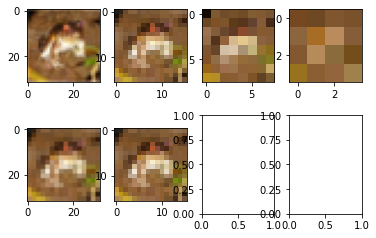

In [ ]:
data_32, _ = next(iter(training_data_32))
data_16, _ = next(iter(training_data_16))
data_8, _ = next(iter(training_data_8))
data_4, _ = next(iter(training_data_4))
fig, ax = plt.subplots(2,4)
ax[0,0].imshow(im_reshape(de_scale(data_32),32))
ax[0,1].imshow(im_reshape(de_scale(data_16),16))
ax[0,2].imshow(im_reshape(de_scale(data_8),8))
ax[0,3].imshow(im_reshape(de_scale(data_4),4))
print(nn.Upsample(scale_factor=2,mode='nearest')(de_scale(data_16).reshape([1,3,16,16])).shape)
ax[1,0].imshow((im_reshape(nn.Upsample(scale_factor=2)(de_scale(data_16).reshape([1,3,16,16])).squeeze(),32)))
ax[1,1].imshow((im_reshape(nn.functional.interpolate((de_scale(data_32).reshape([1,3,32,32])),scale_factor=0.5,mode='bilinear').squeeze(),16)))


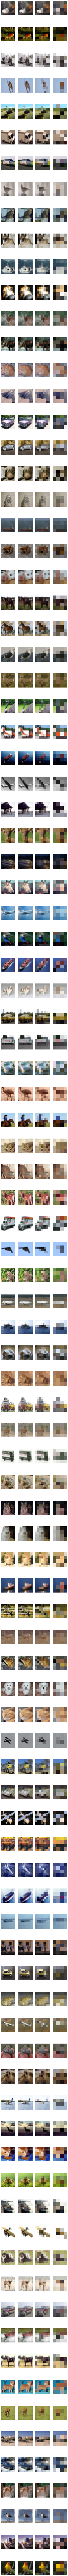

In [ ]:
figure = plt.figure(figsize=(10, 400))
rows = 100
for r in range(0,rows):
    sample_idx = torch.randint(len(training_data_32), size=(1,)).item()
    img_32, _ = training_data_32[sample_idx]
    figure.add_subplot(rows, 4, 4*r+1)
    plt.axis("off")
    plt.imshow(im_reshape(de_scale(img_32),32).squeeze())
    img_16, _ = training_data_16[sample_idx]
    figure.add_subplot(rows, 4, 4*r+2)
    plt.axis("off")
    plt.imshow(im_reshape(de_scale(img_16),16).squeeze())
    img_8, _ = training_data_8[sample_idx]
    figure.add_subplot(rows, 4, 4*r+3)
    plt.axis("off")
    plt.imshow(im_reshape(de_scale(img_8),8).squeeze())
    img_4, _ = training_data_4[sample_idx]
    figure.add_subplot(rows, 4, 4*r+4)
    plt.axis("off")
    plt.imshow(im_reshape(de_scale(img_4),4).squeeze())

# Xây dựng mô hình

In [ ]:
#input is (B,N,W,H)
def FeatureNorm(inp):
    return inp / torch.sqrt(torch.mean(inp**2,dim=1,keepdim=True) + 1e-8)
# exam = torch.empty((2,3,3,3)).normal_()
# print(exam)
# FeatureNorm(exam) 

In [ ]:
def miniBatchStdDev(x, subGroupSize=4):
    size = x.size()
    subGroupSize = min(size[0], subGroupSize)
    if size[0] % subGroupSize != 0:
        subGroupSize = size[0]
    G = int(size[0] / subGroupSize)
    if subGroupSize > 1:
        y = x.view(-1, subGroupSize, size[1], size[2], size[3])
        y = torch.var(y, 1)
        y = torch.sqrt(y + 1e-8)
        y = y.view(G, -1)
        y = torch.mean(y, 1).view(G, 1)
        y = y.expand(G, size[2]*size[3]).view((G, 1, 1, size[2], size[3]))
        y = y.expand(G, subGroupSize, -1, -1, -1)
        y = y.contiguous().view((-1, 1, size[2], size[3]))
    else:
        y = torch.zeros(x.size(0), 1, x.size(2), x.size(3), device=x.device)

    return torch.cat([x, y], dim=1)

# ex = torch.empty((2,2,4,4)).normal_()
# print(ex)
# miniBatchStdDev(ex)


In [ ]:
class G_Block(nn.Module):
    
    def __init__(self,inp,outp,a=0,scale=2):
        super(G_Block,self).__init__()
        self.inp = inp
        self.outp = outp
        self.scale = scale
        if a is None :
            print('Error')
        else:
            self.a = a
        self.upsamp = nn.Upsample(scale_factor=scale,mode='nearest')
        self.conv1 = nn.ConvTranspose2d(inp,inp,3,padding=1)
        self.conv2 = nn.ConvTranspose2d(inp,outp,3,padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.to_RGB = nn.Conv2d(outp,3,1)
        
    def forward(self,im_input,logits_input):
        x = self.upsamp(logits_input)
        x = self.activation(FeatureNorm(self.conv1(x)))
        x = self.activation(FeatureNorm(self.conv2(x)))
        im2 =self.to_RGB(x)
        im1 = self.upsamp(im_input)
        im_output = (1 - self.a)*im1 + self.a*im2
        return im_output, x
    
    def set_a(self,new_a):
        if new_a is None :
            print('Error')
        else:
            self.a = new_a
        print('Done')
    
    def weight_init(self):
        torch.nn.init.kaiming_normal_(self.conv1.weight, a=0.2, mode='fan_out', nonlinearity='leaky_relu')   
        torch.nn.init.kaiming_normal_(self.conv2.weight, a=0.2, mode='fan_out', nonlinearity='leaky_relu')   
        torch.nn.init.kaiming_normal_(self.to_RGB.weight, a=0.2, mode='fan_out', nonlinearity='leaky_relu') 
        print('Done')   
# res = G_Block(128,256,scale=2,a=0.1).to(device)
# rel = G_Block(128,512,scale=4,a=0.4).to(device)
# ex = torch.empty((10,3,8,8),requires_grad = False).normal_().to(device)
# log = torch.empty((10,128,8,8),requires_grad=False).normal_().to(device)
# pytorch_total_params = sum(p.numel() for p in res.parameters()) 
# print('total generator params by 2: ',pytorch_total_params)
# pytorch_total_params = sum(p.numel() for p in rel.parameters()) 
# print('total generator params by 4: ',pytorch_total_params)
# print(f'output shape of this block when padding = 0 : {res(ex,log)[0].shape,res(ex,log)[1].shape,}')
# print(f'output shape of this block when padding = 1 : {rel(ex,log)[0].shape,rel(ex,log)[1].shape}')
# rel.set_a(None)
# print(f'output shape of this block when padding = 1 : {rel(ex,log)[0].shape,rel(ex,log)[1].shape}')
# rel.set_a(0)
# print(f'output shape of this block when padding = 1 : {rel(ex,log)[0].shape,rel(ex,log)[1].shape}')

In [ ]:

class D_Block(nn.Module):
    
    def __init__(self,inp,outp,a=0,scale=.5,mnbstd=False):
        super(D_Block,self).__init__()
        if not mnbstd:
            self.inp = inp
            self.f_inp = inp
        else:
            self.inp = inp+1
            self.f_inp = inp
        self.outp = outp
        self.mnbstd = mnbstd
        if a is None :
            print('Error')
        else:
            self.a = a
        self.scale = scale
        self.conv1 = nn.Conv2d(outp,outp,3,padding=1)
        self.conv2 = nn.Conv2d(self.inp,outp,3,padding=1)
        self.activations = nn.LeakyReLU(0.2)
        self.from_rgb = nn.Conv2d(3,inp,1)
        
    def forward(self,im_inp,logits_inp):
        im_outp = nn.functional.interpolate(im_inp,scale_factor=self.scale,mode='bilinear')
        split = self.from_rgb(im_inp)
        x = (1-self.a)*split + self.a*logits_inp
        if self.mnbstd:
            x = miniBatchStdDev(x)
        x = self.activations(self.conv2(x))
        x = self.activations(self.conv1(x))
        logits_outp = nn.functional.interpolate(x,scale_factor=self.scale,mode='bilinear')
        return im_outp, logits_outp
    
    def set_a(self,new_a):
        if new_a is None :
            print('Error')
        else:
            self.a = new_a
        print('Done')
        
    def weight_init(self):
        torch.nn.init.kaiming_normal_(self.conv1.weight, a=0.2, mode='fan_out', nonlinearity='leaky_relu')   
        torch.nn.init.kaiming_normal_(self.conv2.weight, a=0.2, mode='fan_out', nonlinearity='leaky_relu')   
        torch.nn.init.kaiming_normal_(self.from_rgb.weight, a=0.2, mode='fan_out', nonlinearity='leaky_relu') 
        print('Done')        
# rel = D_Block(512,256,a=0,mnbstd=True).to(device)
# rel.set_a(0.2)
# res = D_Block(512,256,a=.4,mnbstd=True).to(device)
# res.set_a(None)
# ex = torch.empty((2,3,32,32),requires_grad = False).normal_().to(device)
# log = torch.empty((2,512,32,32),requires_grad = False).normal_().to(device)
# pytorch_total_params = sum(p.numel() for p in res.parameters()) 
# print('total generator params by 2: ',pytorch_total_params)
# pytorch_total_params = sum(p.numel() for p in rel.parameters()) 
# print('total generator params by 4: ',pytorch_total_params)
# print(f'output shape of this block when resample = down : {rel(ex,log)[0].shape}')
# print(f'output shape of this block when resample = None : {res(ex,log)[1].shape}')
# print(f'output shape of this block when resample = down : {rel(ex,log)[0].shape}')
# print(f'output shape of this block when resample = None : {res(ex,log)[1].shape}')   

In [ ]:
class BlockSequence(nn.Sequential):
    
    def forward(self, im_inp,logits_inp):
        for module in self:
            im_inp, logits_inp = module(im_inp,logits_inp)
        return im_inp, logits_inp

In [ ]:
class P_gen(nn.Module):
    
    def __init__(self,layer_list = None):
        super(P_gen,self).__init__()
        self.layer_list = layer_list
        self.model = BlockSequence(*layer_list)
        
    def forward(self,logits):
        batch_size = logits.shape[0]
        return self.model(torch.zeros(batch_size,3,1,1,device=device),logits)[0]
    
    def adjust_list(self,layer_list):
        self.layer_list = layer_list
        self.model = BlockSequence(*layer_list)
        print('Done')
# layer_list = [G_Block(256,128,a=1,scale=4).to(device),
#               G_Block(128,3,a=0).to(device)]
# generator = P_gen(layer_list).to(device)
# print(generator.layer_list)
# im = torch.zeros(5,3,1,1)
# rand = torch.empty((5,256,1,1)).normal_().to(device)
# print(generator(rand).shape)
# pytorch_total_params = sum(p.numel() for p in generator.parameters()) 
# print('total generator params: ',pytorch_total_params)
# layer_list.append(G_Block(3,123,a=.5).to(device))
# generator.adjust_list(layer_list)
# print(torch.min(generator(rand)))

In [ ]:
class P_dis(nn.Module):
    
    def __init__(self,layer_list):
        super(P_dis,self).__init__()
        self.layer_list = layer_list
        self.model = BlockSequence(*layer_list)
        self.linear = nn.Linear(layer_list[-1].outp*2,1)
        self.flatten = nn.Flatten()
        self.conv = nn.Conv2d(layer_list[-1].outp,layer_list[-1].outp,1)
        self.batch = nn.BatchNorm2d(layer_list[-1].outp,affine=False)
        self.activations = nn.LeakyReLU(0.2)
        self.drop = nn.Dropout(0.25)
        
    def forward(self,im_inp):
        batch_size, chanel, res = im_inp.shape[0], self.layer_list[0].f_inp, im_inp.shape[-1]
        logits = self.model(im_inp,torch.zeros(batch_size,chanel,res,res,device=device))[-1]
        logits = self.conv(logits)
        var = self.batch(logits)
        logits = self.activations(logits)
        cat = torch.cat([logits,var],dim=1)
        logits = self.flatten(cat)
        logits = self.drop(logits)
        logits = self.linear(logits) 
        return logits
    
    def adjust_list(self,layer_list):
        self.layer_list = layer_list
        self.model = BlockSequence(*layer_list)
        print('Done')
layer_list = [D_Block(128,256,a=0.2).to(device),
              D_Block(256,256,a=1).to(device)
              ]
discriminator = P_dis(layer_list).to(device)
rand=torch.empty((2,3,4,4)).normal_().to(device)
u=discriminator(rand)
print('discri: ',u.shape)
pytorch_total_params = sum(p.numel() for p in discriminator.parameters()) 
print('total discriminator params: ',pytorch_total_params)

discri:  torch.Size([2, 1])
total discriminator params:  2133249


# Khởi tạo mô hình để huấn luyện

In [ ]:
layer1_gen = G_Block(256,128,a=1,scale=4).to(device)
layer2_gen = G_Block(128,64 ,a=0,scale=2).to(device)
layer3_gen = G_Block(64 ,32 ,a=0,scale=2).to(device)
layer4_gen = G_Block(32 ,32 ,a=0,scale=2).to(device)
layer_list_gen = [
    layer1_gen,
    layer2_gen,
    layer3_gen,
    layer4_gen,
]
for layer in layer_list_gen:
    layer.weight_init()
i = 1
generator = P_gen(layer_list_gen[:i]).to(device)
print(layer_list_gen[:i])
pytorch_total_params = sum(p.numel() for p in generator.parameters()) 
print('total params: ',pytorch_total_params)

Done
Done
Done
Done
[G_Block(
  (upsamp): Upsample(scale_factor=4.0, mode=nearest)
  (conv1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): LeakyReLU(negative_slope=0.2)
  (to_RGB): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
)]
total params:  885507


In [ ]:
layer1_dis = D_Block(128,256,a=0,scale=.25,mnbstd=True).to(device)
layer2_dis = D_Block(64,128,a=0,scale=.5 ).to(device)
layer3_dis = D_Block(32 ,64,a=0,scale=.5 ).to(device)
layer4_dis = D_Block(32 ,32 ,a=0,scale=.5 ).to(device)
layer_list_dis = [
    layer4_dis,
    layer3_dis,
    layer2_dis,
    layer1_dis,
]
for layer in layer_list_dis:
    layer.weight_init()
i = 1
discriminator = P_dis(layer_list_dis[-i:]).to(device)
print(layer_list_dis[-i:])
pytorch_total_params = sum(p.numel() for p in discriminator.parameters()) 
print('total params: ',pytorch_total_params)

Done
Done
Done
Done
[D_Block(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(129, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activations): LeakyReLU(negative_slope=0.2)
  (from_rgb): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
)]
total params:  954369


In [ ]:
rand = torch.empty(256,256,1,1).to(device)
inp = generator(rand)
print(inp.shape)
outp = discriminator(inp) 
print(outp.shape)

torch.Size([256, 3, 4, 4])
torch.Size([256, 1])


# HUẤN LUYỆN MODEL $4\times4$

In [ ]:
size=4
batch_size=256
epochs=16
latent=256

learning_rate=0.001
n_critics=1
n_student=1

tau=10
epsilon=750
drift=0.001

generator=generator.to(device)
discriminator=discriminator.to(device)
dis_optimizer=torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_optimizer=torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.,0.99))
#gen_checkpoint,dis_checkpoint=load_model(size,generator,discriminator,gen_optimizer,dis_optimizer)
incep=InceptionScore(device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
data=DataLoader(training_data_4,batch_size=batch_size,shuffle=True)

In [ ]:
#generator_history = gen_checkpoint['loss']
#discriminator_history = dis_checkpoint['loss']

In [ ]:
generator_history,discriminator_history,Incep_Score = init_state()

In [ ]:
for epoch in range(epochs):
    tim = t.time()
    
    for itter ,(X,Y) in enumerate(data):
        X = X.to(device)  
        batch_size=len(X)
        
        #HUAN LUYEN DISCRIMINATOR
        dis_optimizer.zero_grad()
        
        #get a batch of random tensor and fake data
        random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
        lambda_v = torch.rand((batch_size, 1, 1, 1)).to(device)
        fake_data = generator(random_vector)
        X.requires_grad = True
        meta = lambda_v*X + (1-lambda_v)*fake_data
        output = discriminator(meta)

        #gradient penalty
        norm=get_grad_norm(output,meta,epsilon)
        
        #train on REAL data
        real_discriminator_score = discriminator(X)
        
        #train on FAKE data
        fake_discriminator_score = discriminator(fake_data)
        
        #calculate loss
        
        fake_dis_loss , real_dis_loss = w_loss_dis(fake_discriminator_score,real_discriminator_score)
        sum_dis_loss = (fake_dis_loss - real_dis_loss 
                        + tau*norm + ( real_dis_loss**2) *drift )/(float(n_critics))

        #back-propagation
        sum_dis_loss.backward()
        dis_optimizer.step()
        
        #HUAN LUYEN GENERATOR
        if itter % n_critics == 0:
            for n in range(n_student):
                gen_optimizer.zero_grad()
                
                #get a batch of random tensor and fake data
                random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
            
                #get discriminator output
                discriminator_score_gen = discriminator(generator(random_vector))
                
                #calculate loss
                gen_loss = - w_loss_gen(discriminator_score_gen)/float(n_student)
                
                #back propagation
                gen_loss.backward()
                gen_optimizer.step()

        #LUU CAC THONG SO NOI
        generator_history['generator_loss'].append(gen_loss.item())
        discriminator_history['sum_discriminator_loss'].append(sum_dis_loss.item())
        discriminator_history['discriminator_loss'].append((real_dis_loss-fake_dis_loss).item())
        discriminator_history['discriminator_mean_score_on_both'].append((real_discriminator_score.mean().item()+fake_discriminator_score.mean().item())/2)
        discriminator_history['gradient norm'].append(norm.item())

        # HIEN THI THONG SO
        if (itter+1) % (len(data)//10) == 0:
            tim = t.time() - tim
            remain = ((epochs - epoch ) * 10 - ((itter+1) // (len(data)//10)) ) * tim
            print(f'[{epoch}/{epochs}][{itter}/{len(data)}]: {round(tim,2)}  remain {t.strftime("%H:%M:%S", t.gmtime(remain))}  Loss_D: {(real_dis_loss - fake_dis_loss).item()}  Loss_G: {gen_loss.item()}  norm: {norm.item()} ')
            tim = t.time()
    
    #TINH INCEPTION SCORE
    incep.update(interpolate(fake_data).cuda())
    Incep_Score.append(incep.compute())
    
    save_model(size)
    print(f'model saved, InceptionScore: {Incep_Score[-1]}')
    outp = make_grid(de_scale(generator(randim).squeeze().cpu().detach()),nrow=3)
    save_image(outp,f'/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/mnbstd_image/gen_size{size}_{epoch}.png')

[0/16][18/196]: 4.9  remain 00:12:58  Loss_D: -283.4681396484375  Loss_G: 34.35191345214844  norm: 0.4087020754814148 
[0/16][37/196]: 3.9  remain 00:10:16  Loss_D: 482.64984130859375  Loss_G: 511.88006591796875  norm: 0.5476118922233582 
[0/16][56/196]: 3.87  remain 00:10:08  Loss_D: 8712.900390625  Loss_G: 28024.330078125  norm: 81.81925964355469 
[0/16][75/196]: 3.86  remain 00:10:01  Loss_D: -1741.67529296875  Loss_G: 233.7069091796875  norm: 34.78356170654297 
[0/16][94/196]: 3.86  remain 00:09:57  Loss_D: -1265.6866455078125  Loss_G: -1070.0416259765625  norm: 7.239640235900879 
[0/16][113/196]: 3.85  remain 00:09:52  Loss_D: -32.18341064453125  Loss_G: -582.967041015625  norm: 2.3115360736846924 
[0/16][132/196]: 3.87  remain 00:09:52  Loss_D: -118.65576171875  Loss_G: -409.4232177734375  norm: 1.2877788543701172 
[0/16][151/196]: 3.89  remain 00:09:51  Loss_D: 368.15673828125  Loss_G: 155.0376434326172  norm: 3.142261505126953 
[0/16][170/196]: 3.84  remain 00:09:39  Loss_D: 25

/content/ignite/ignite/metrics/gan/inception_score.py:96: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(inception_output)


model saved, InceptionScore: 1.1709085702896118
[1/16][18/196]: 4.11  remain 00:10:12  Loss_D: 150.70468139648438  Loss_G: -126.61853790283203  norm: 1.336824655532837 
[1/16][37/196]: 4.27  remain 00:10:31  Loss_D: 368.9801940917969  Loss_G: 124.1111068725586  norm: 1.1727511882781982 
[1/16][56/196]: 3.93  remain 00:09:37  Loss_D: 262.8811950683594  Loss_G: 257.4939270019531  norm: 0.9583529233932495 
[1/16][75/196]: 3.89  remain 00:09:28  Loss_D: -177.06979370117188  Loss_G: 835.0572509765625  norm: 2.455465078353882 
[1/16][94/196]: 3.9  remain 00:09:25  Loss_D: 385.25421142578125  Loss_G: 431.01702880859375  norm: 0.5682846307754517 
[1/16][113/196]: 3.91  remain 00:09:22  Loss_D: 117.0702896118164  Loss_G: 227.63438415527344  norm: 1.5821173191070557 
[1/16][132/196]: 3.91  remain 00:09:19  Loss_D: -548.797119140625  Loss_G: -383.32232666015625  norm: 1.5485535860061646 
[1/16][151/196]: 3.95  remain 00:09:20  Loss_D: 194.63998413085938  Loss_G: 194.955322265625  norm: 0.99213731

RuntimeError: ignored

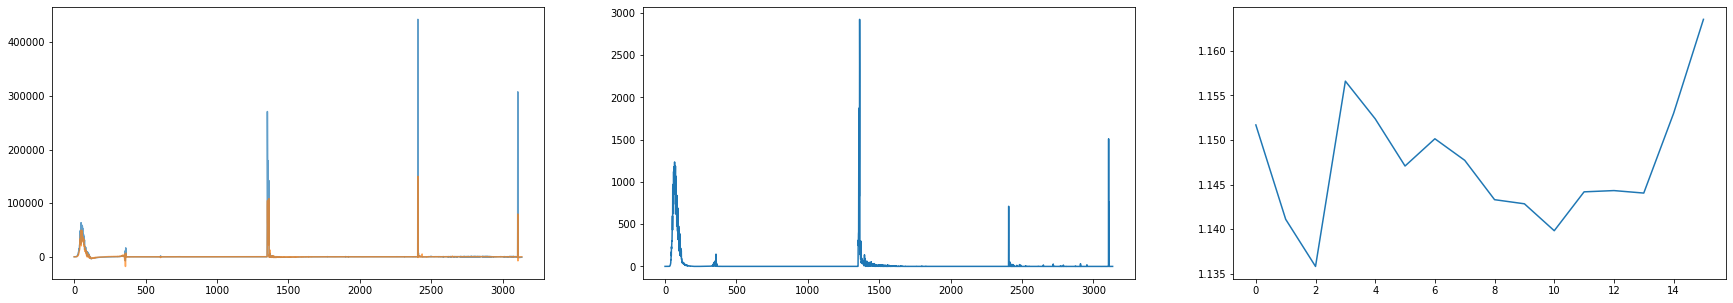

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(30,5))
ax[0].plot(generator_history['generator_loss'],alpha=0.7)
ax[0].plot(discriminator_history['discriminator_loss'],alpha=0.7)
ax[1].plot(discriminator_history['gradient norm'])
ax[2].plot(Incep_Score)

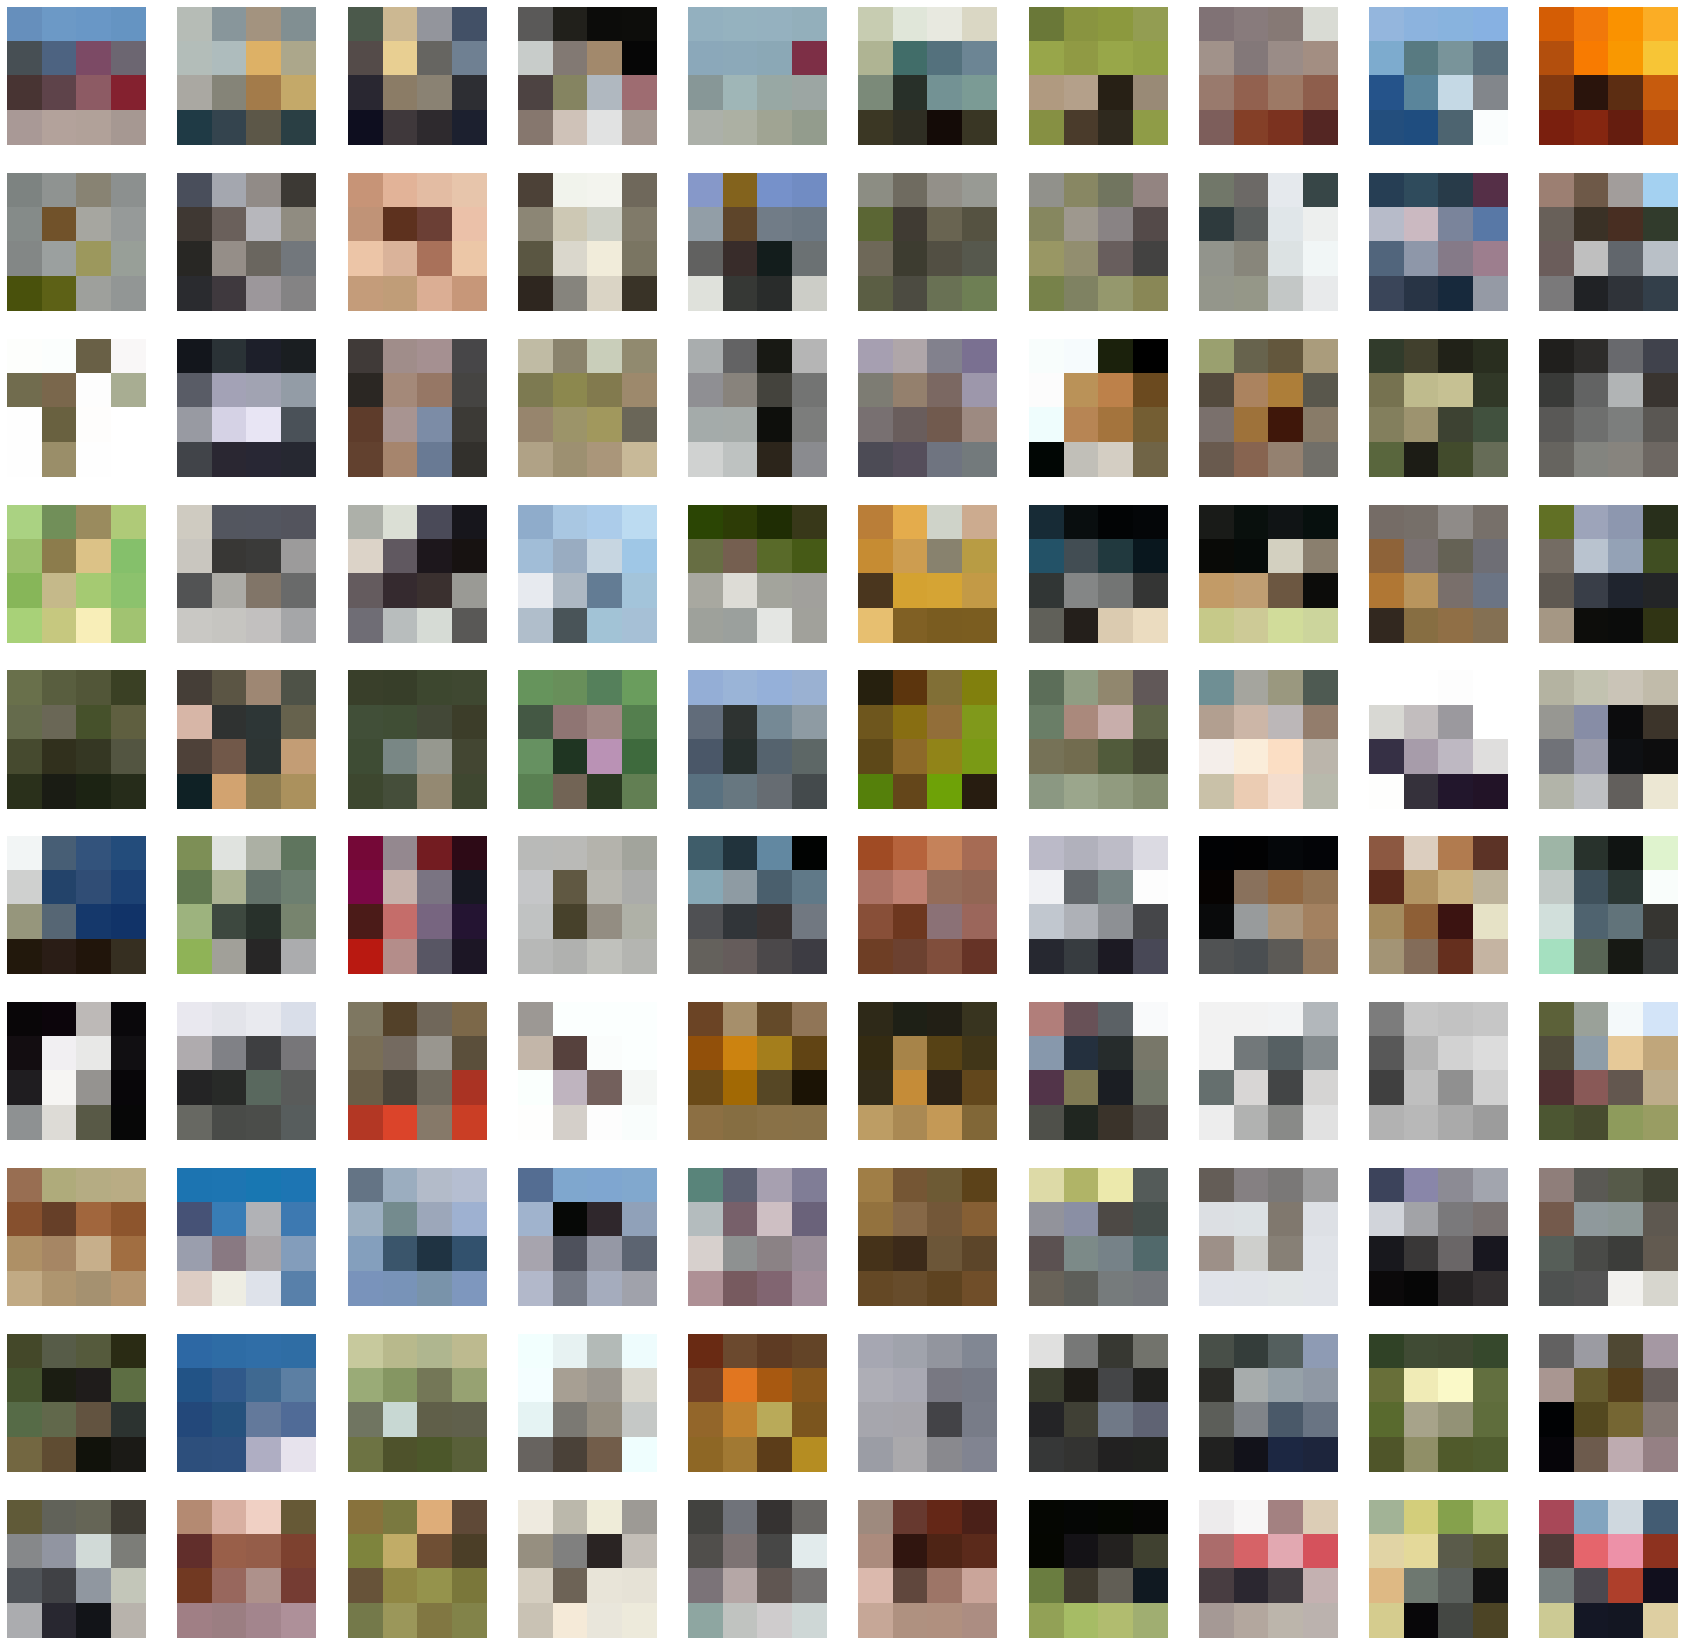

In [ ]:
figure = plt.figure(figsize=(30, 30))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    sample_idx = torch.randint(len(training_data_4), size=(1,)).item()
    img, label = training_data_4[sample_idx]
    plt.imshow(im_reshape(de_scale(img),size).squeeze())
    #print(torch.max(im[i-1]), torch.min(im[i-1]))
plt.show()

# HUẤN LUYỆN MODEL $8\times 8$

In [ ]:
size=8
batch_size=256
epochs=32
latent=256

learning_rate=0.001
n_critics=1
n_student=1

tau=10
epsilon=750
drift=0.001

generator=generator.to(device)
discriminator=discriminator.to(device)
dis_optimizer=torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_optimizer=torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_checkpoint,dis_checkpoint=load_model(4,generator,discriminator,gen_optimizer,dis_optimizer)
incep=InceptionScore(device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
generator.adjust_list(layer_list_gen[:2])
discriminator.adjust_list(layer_list_dis[-2:])
dis_optimizer=torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_optimizer=torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.,0.99))
# for i in generator.layer_list[-1].children():
#     for k in i.parameters():
#         print(k)

Done
Done


In [ ]:
layer2_gen.set_a(0.1)
layer1_dis.set_a(0.1)
jump_dict = {}
jumps = torch.linspace(0,1,16).to(device)
print(jumps.shape)
for i,jump in enumerate(jumps):
    jump_dict[str(i)] = jump
for i in range(16,epochs):
    jump_dict[str(i)] = torch.as_tensor(1).to(device)
print(len(jump_dict))
print(jump_dict)

Done
Done
torch.Size([16])
32
{'0': tensor(0., device='cuda:0'), '1': tensor(0.0667, device='cuda:0'), '2': tensor(0.1333, device='cuda:0'), '3': tensor(0.2000, device='cuda:0'), '4': tensor(0.2667, device='cuda:0'), '5': tensor(0.3333, device='cuda:0'), '6': tensor(0.4000, device='cuda:0'), '7': tensor(0.4667, device='cuda:0'), '8': tensor(0.5333, device='cuda:0'), '9': tensor(0.6000, device='cuda:0'), '10': tensor(0.6667, device='cuda:0'), '11': tensor(0.7333, device='cuda:0'), '12': tensor(0.8000, device='cuda:0'), '13': tensor(0.8667, device='cuda:0'), '14': tensor(0.9333, device='cuda:0'), '15': tensor(1., device='cuda:0'), '16': tensor(1, device='cuda:0'), '17': tensor(1, device='cuda:0'), '18': tensor(1, device='cuda:0'), '19': tensor(1, device='cuda:0'), '20': tensor(1, device='cuda:0'), '21': tensor(1, device='cuda:0'), '22': tensor(1, device='cuda:0'), '23': tensor(1, device='cuda:0'), '24': tensor(1, device='cuda:0'), '25': tensor(1, device='cuda:0'), '26': tensor(1, device=

In [ ]:
data=DataLoader(training_data_8,batch_size=batch_size,shuffle=True)

In [ ]:
generator_history,discriminator_history,Incep_Score = init_state()

In [ ]:
for epoch in range(epochs):
    tim = t.time()
    
    layer2_gen.set_a(jump_dict[str(epoch)])
    layer1_dis.set_a(jump_dict[str(epoch)])

    for itter ,(X,Y) in enumerate(data):
        X = X.to(device) 
        batch_size=len(X)
        
        #HUAN LUYEN DISCRIMINATOR
        dis_optimizer.zero_grad()
        
        #get a batch of random tensor and fake data
        random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
        lambda_v = torch.rand((batch_size, 1, 1, 1)).to(device)
        fake_data = generator(random_vector)
        X.requires_grad = True
        meta = lambda_v*X + (1-lambda_v)*fake_data
        output = discriminator(meta)

        #gradient penalty
        norm=get_grad_norm(output,meta,epsilon)
        
        #train on REAL data
        real_discriminator_score = discriminator(X)
        
        #train on FAKE data
        fake_discriminator_score = discriminator(fake_data)
        
        #calculate loss
        
        fake_dis_loss , real_dis_loss = w_loss_dis(fake_discriminator_score,real_discriminator_score)
        sum_dis_loss = (fake_dis_loss - real_dis_loss
                        + tau*norm + ( real_dis_loss**2)*drift)/(float(n_critics))

        #back-propagation
        sum_dis_loss.backward()
        dis_optimizer.step()
        
        #HUAN LUYEN GENERATOR
        if itter % n_critics == 0:
            for n in range(n_student):
                gen_optimizer.zero_grad()
                
                #get a batch of random tensor and fake data
                random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
            
                #get discriminator output
                discriminator_score_gen = discriminator(generator(random_vector))
                
                #calculate loss
                gen_loss = - w_loss_gen(discriminator_score_gen)/float(n_student)
                
                #back propagation
                gen_loss.backward()
                gen_optimizer.step()
        
        #LUU CAC THONG SO NOI
        generator_history['generator_loss'].append(gen_loss.item())
        discriminator_history['sum_discriminator_loss'].append(sum_dis_loss.item())
        discriminator_history['discriminator_loss'].append((real_dis_loss-fake_dis_loss).item())
        discriminator_history['discriminator_mean_score_on_both'].append((real_discriminator_score.mean().item()+fake_discriminator_score.mean().item())/2)
        discriminator_history['gradient norm'].append(norm.item())
        # HIEN THI THONG SO
        if (itter+1) % (len(data)//10) == 0:
            tim = t.time() - tim
            remain = ((epochs - epoch ) * 10 - ((itter+1) // (len(data)//10)) ) * tim
            print(f'[{epoch}/{epochs}][{itter}/{len(data)}]: {round(tim,2)}  remain {t.strftime("%H:%M:%S", t.gmtime(remain))}  Loss_D: {(real_dis_loss - fake_dis_loss).item()}  Loss_G: {gen_loss.item()}  norm: {norm.item()} ')
            tim = t.time()

    #TINH INCEPTION SCORE
    incep.update(interpolate(fake_data))
    Incep_Score.append(incep.compute())
    
    save_model(size)
    print(f'model saved, InceptionScore: {Incep_Score[-1]}')
    outp = make_grid(de_scale(generator(randim).squeeze().cpu().detach()),nrow=3)
    save_image(outp,f'/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/mnbstd_image/gen_size{size}_{epoch}.png')

Done
Done
[0/32][18/196]: 5.76  remain 00:30:37  Loss_D: 108.193603515625  Loss_G: 345.353759765625  norm: 0.6906675100326538 
[0/32][37/196]: 5.66  remain 00:30:00  Loss_D: -227.2689971923828  Loss_G: -256.6807861328125  norm: 0.513455867767334 
[0/32][56/196]: 5.85  remain 00:30:54  Loss_D: 75.91324615478516  Loss_G: 135.9591064453125  norm: 0.5362889766693115 
[0/32][75/196]: 5.7  remain 00:30:01  Loss_D: 91.2518539428711  Loss_G: 190.34124755859375  norm: 0.521963357925415 
[0/32][94/196]: 5.63  remain 00:29:32  Loss_D: 81.04672241210938  Loss_G: 222.45533752441406  norm: 0.5599830746650696 
[0/32][113/196]: 5.63  remain 00:29:29  Loss_D: 102.17950439453125  Loss_G: -213.67092895507812  norm: 0.4428178668022156 
[0/32][132/196]: 6.11  remain 00:31:51  Loss_D: 52.10606384277344  Loss_G: -76.28355407714844  norm: 0.5942881107330322 
[0/32][151/196]: 5.66  remain 00:29:27  Loss_D: 32.82102966308594  Loss_G: 108.74189758300781  norm: 0.6329747438430786 
[0/32][170/196]: 5.7  remain 00:

KeyboardInterrupt: ignored

In [ ]:
# for i in generator.layer_list[-1].children():
#     for k in i.parameters():
#         print(k)

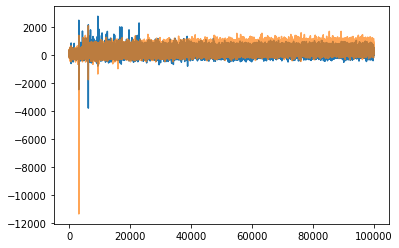

In [ ]:
plt.plot(generator_history['generator_loss'])
plt.plot(discriminator_history['discriminator_loss'],alpha=.7)

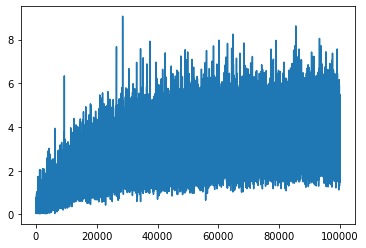

In [ ]:
plt.plot(discriminator_history['gradient norm'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 8, 8])
['máy bay', 'xe hơi', 'con chim', 'con mèo', 'con hươu', 'con chó', 'con ếch', 'ngựa', 'thuyền', 'xe tải']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

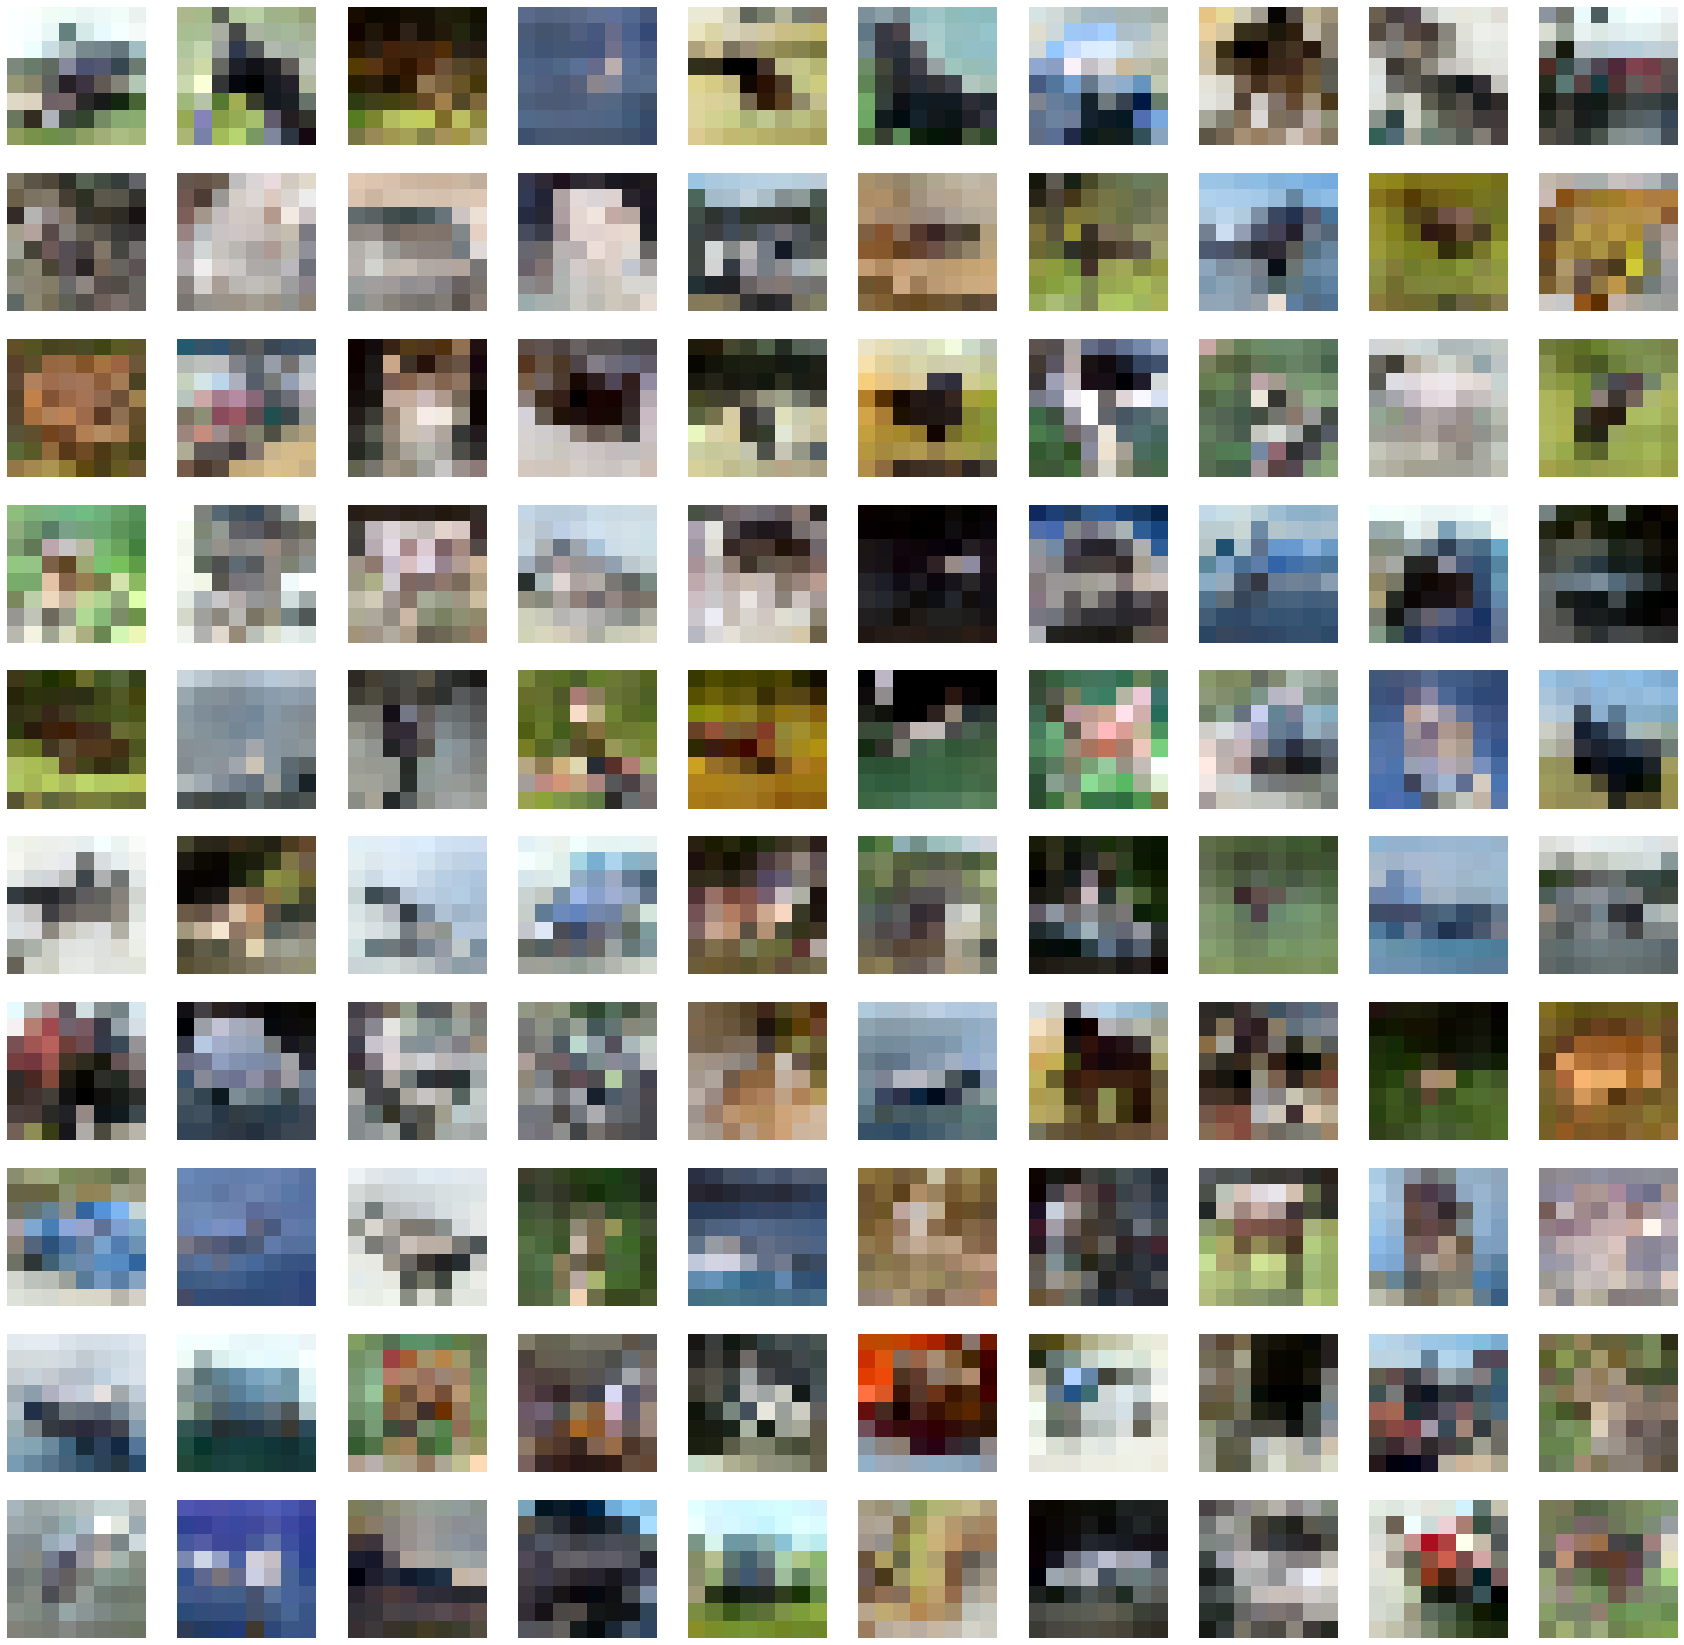

In [ ]:
random_vector = torch.empty((100,latent,1,1)).normal_(std=1).to(device)
gen_checkpoint,dis_checkpoint=load_model(8,generator,discriminator,gen_optimizer,dis_optimizer)
im=generator(random_vector)
print(im.shape)
print(['máy bay','xe hơi','con chim','con mèo','con hươu','con chó','con ếch','ngựa','thuyền','xe tải'])
figure = plt.figure(figsize=(30, 30))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(im_reshape(de_scale(im[i-1].cpu().detach()),8).squeeze())
    #print(torch.max(im[i-1]), torch.min(im[i-1]))
plt.show()

# HUẤN LUYỆN MODEL $16×16$

In [ ]:
size=16
batch_size=16
epochs=32
latent=256

learning_rate=0.001
n_critics=1
n_student=1

tau=10
epsilon=750
drift=0.001

generator.adjust_list(layer_list_gen[:2])
discriminator.adjust_list(layer_list_dis[-2:])
generator=generator.to(device)
discriminator=discriminator.to(device)
dis_optimizer=torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_optimizer=torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_checkpoint,dis_checkpoint=load_model(8,generator,discriminator,gen_optimizer,dis_optimizer)

Done
Done


In [ ]:
generator.adjust_list(layer_list_gen[:3])
discriminator.adjust_list(layer_list_dis[-3:])
layer3_gen.set_a(0.1)
layer2_gen.set_a(1.)
layer2_dis.set_a(0.1)
layer1_dis.set_a(1.)
dis_optimizer=torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_optimizer=torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.,0.99))
jump_dict = {}
jumps = torch.linspace(0,1,16).to(device)
print(jumps.shape)
for i,jump in enumerate(jumps):
    jump_dict[str(i)] = jump
for i in range(16,epochs):
    jump_dict[str(i)] = torch.as_tensor(1).to(device)
print(len(jump_dict))
print(jump_dict)

Done
Done
Done
Done
Done
Done
torch.Size([16])
32
{'0': tensor(0., device='cuda:0'), '1': tensor(0.0667, device='cuda:0'), '2': tensor(0.1333, device='cuda:0'), '3': tensor(0.2000, device='cuda:0'), '4': tensor(0.2667, device='cuda:0'), '5': tensor(0.3333, device='cuda:0'), '6': tensor(0.4000, device='cuda:0'), '7': tensor(0.4667, device='cuda:0'), '8': tensor(0.5333, device='cuda:0'), '9': tensor(0.6000, device='cuda:0'), '10': tensor(0.6667, device='cuda:0'), '11': tensor(0.7333, device='cuda:0'), '12': tensor(0.8000, device='cuda:0'), '13': tensor(0.8667, device='cuda:0'), '14': tensor(0.9333, device='cuda:0'), '15': tensor(1., device='cuda:0'), '16': tensor(1, device='cuda:0'), '17': tensor(1, device='cuda:0'), '18': tensor(1, device='cuda:0'), '19': tensor(1, device='cuda:0'), '20': tensor(1, device='cuda:0'), '21': tensor(1, device='cuda:0'), '22': tensor(1, device='cuda:0'), '23': tensor(1, device='cuda:0'), '24': tensor(1, device='cuda:0'), '25': tensor(1, device='cuda:0'), '26

In [ ]:
data=DataLoader(training_data_16,batch_size=batch_size,shuffle=True)

In [ ]:
generator_history,discriminator_history = init_state()

In [ ]:
for epoch in range(epochs):
    tim = t.time()
    
    layer3_gen.set_a(jump_dict[str(epoch)])
    layer2_dis.set_a(jump_dict[str(epoch)])

    for itter ,(X,Y) in enumerate(data):
        X = X.to(device) 
        batch_size=len(X)
        
        #HUAN LUYEN DISCRIMINATOR
        dis_optimizer.zero_grad()
        
        #get a batch of random tensor and fake data
        random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
        lambda_v = torch.rand((batch_size, 1, 1, 1)).to(device)
        fake_data = generator(random_vector)
        X.requires_grad = True
        meta = lambda_v*X + (1-lambda_v)*fake_data
        output = discriminator(meta)

        #gradient penalty
        norm=get_grad_norm(output,meta,epsilon)
        
        #train on REAL data
        real_discriminator_score = discriminator(X)
        
        #train on FAKE data
        fake_discriminator_score = discriminator(fake_data)
        
        #calculate loss
        
        fake_dis_loss , real_dis_loss = w_loss_dis(fake_discriminator_score,real_discriminator_score)
        sum_dis_loss = (fake_dis_loss - real_dis_loss
                        + tau*norm + (fake_dis_loss**2 + real_dis_loss**2)*drift)/(float(n_critics))

        #back-propagation
        sum_dis_loss.backward()
        dis_optimizer.step()
        
        #HUAN LUYEN GENERATOR
        if itter % n_critics == 0:
            for n in range(n_student):
                gen_optimizer.zero_grad()
                
                #get a batch of random tensor and fake data
                random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
            
                #get discriminator output
                discriminator_score_gen = discriminator(generator(random_vector))
                
                #calculate loss
                gen_loss = - w_loss_gen(discriminator_score_gen)/float(n_student)
                
                #back propagation
                gen_loss.backward()
                gen_optimizer.step()
        
        #LUU CAC THONG SO NOI
        generator_history['generator_loss'].append(gen_loss.item())
        discriminator_history['sum_discriminator_loss'].append(sum_dis_loss.item())
        discriminator_history['discriminator_loss'].append((real_dis_loss-fake_dis_loss).item())
        discriminator_history['discriminator_mean_score_on_both'].append((real_discriminator_score.mean().item()+fake_discriminator_score.mean().item())/2)
        discriminator_history['gradient norm'].append(norm.item())
        # HIEN THI THONG SO
        if (itter+1) % (len(data)//10) == 0:
            tim = t.time() - tim
            remain = ((epochs - epoch ) * 10 - ((itter+1) // (len(data)//10)) ) * tim
            print(f'[{epoch}/{epochs}][{itter}/{len(data)}]: {round(tim,2)}  remain {t.strftime("%H:%M:%S", t.gmtime(remain))}  Loss_D: {(real_dis_loss - fake_dis_loss).item()}  Loss_G: {gen_loss.item()}  norm: {norm.item()} ')
            tim = t.time()
    save_model(size)
    print('model saved')
    outp = make_grid(de_scale(generator(randim).squeeze().cpu().detach()),nrow=3)
    save_image(outp,f'/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/mnbstd_image/gen_size{size}_{epoch}.png')

Done
Done
[0/32][311/3125]: 15.24  remain 01:21:02  Loss_D: 635.8974609375  Loss_G: 346.0893249511719  norm: 0.5304021835327148 
[0/32][623/3125]: 15.68  remain 01:23:07  Loss_D: 75.4993896484375  Loss_G: 132.01608276367188  norm: 0.7651873826980591 
[0/32][935/3125]: 14.97  remain 01:19:06  Loss_D: 239.4452667236328  Loss_G: 288.6122741699219  norm: 0.6759172081947327 
[0/32][1247/3125]: 15.0  remain 01:19:01  Loss_D: 373.8959045410156  Loss_G: -143.34652709960938  norm: 1.1644700765609741 
[0/32][1559/3125]: 14.9  remain 01:18:12  Loss_D: 113.02032470703125  Loss_G: 83.88276672363281  norm: 1.6197997331619263 
[0/32][1871/3125]: 14.95  remain 01:18:15  Loss_D: 365.2432861328125  Loss_G: 52.94361114501953  norm: 1.2629259824752808 
[0/32][2183/3125]: 15.08  remain 01:18:41  Loss_D: 1056.29541015625  Loss_G: 179.74148559570312  norm: 1.552330732345581 
[0/32][2495/3125]: 14.88  remain 01:17:21  Loss_D: 955.002685546875  Loss_G: 540.0656127929688  norm: 2.1288235187530518 
[0/32][2807/3

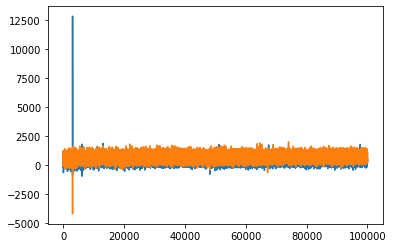

In [ ]:
plt.plot(generator_history['generator_loss'])
plt.plot(discriminator_history['discriminator_loss'])

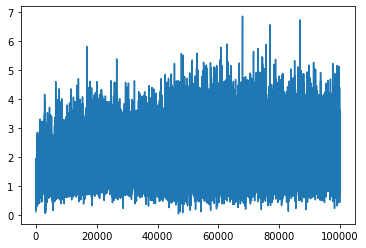

In [ ]:
plt.plot(discriminator_history['gradient norm'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 16, 16])
['máy bay', 'xe hơi', 'con chim', 'con mèo', 'con hươu', 'con chó', 'con ếch', 'ngựa', 'thuyền', 'xe tải']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

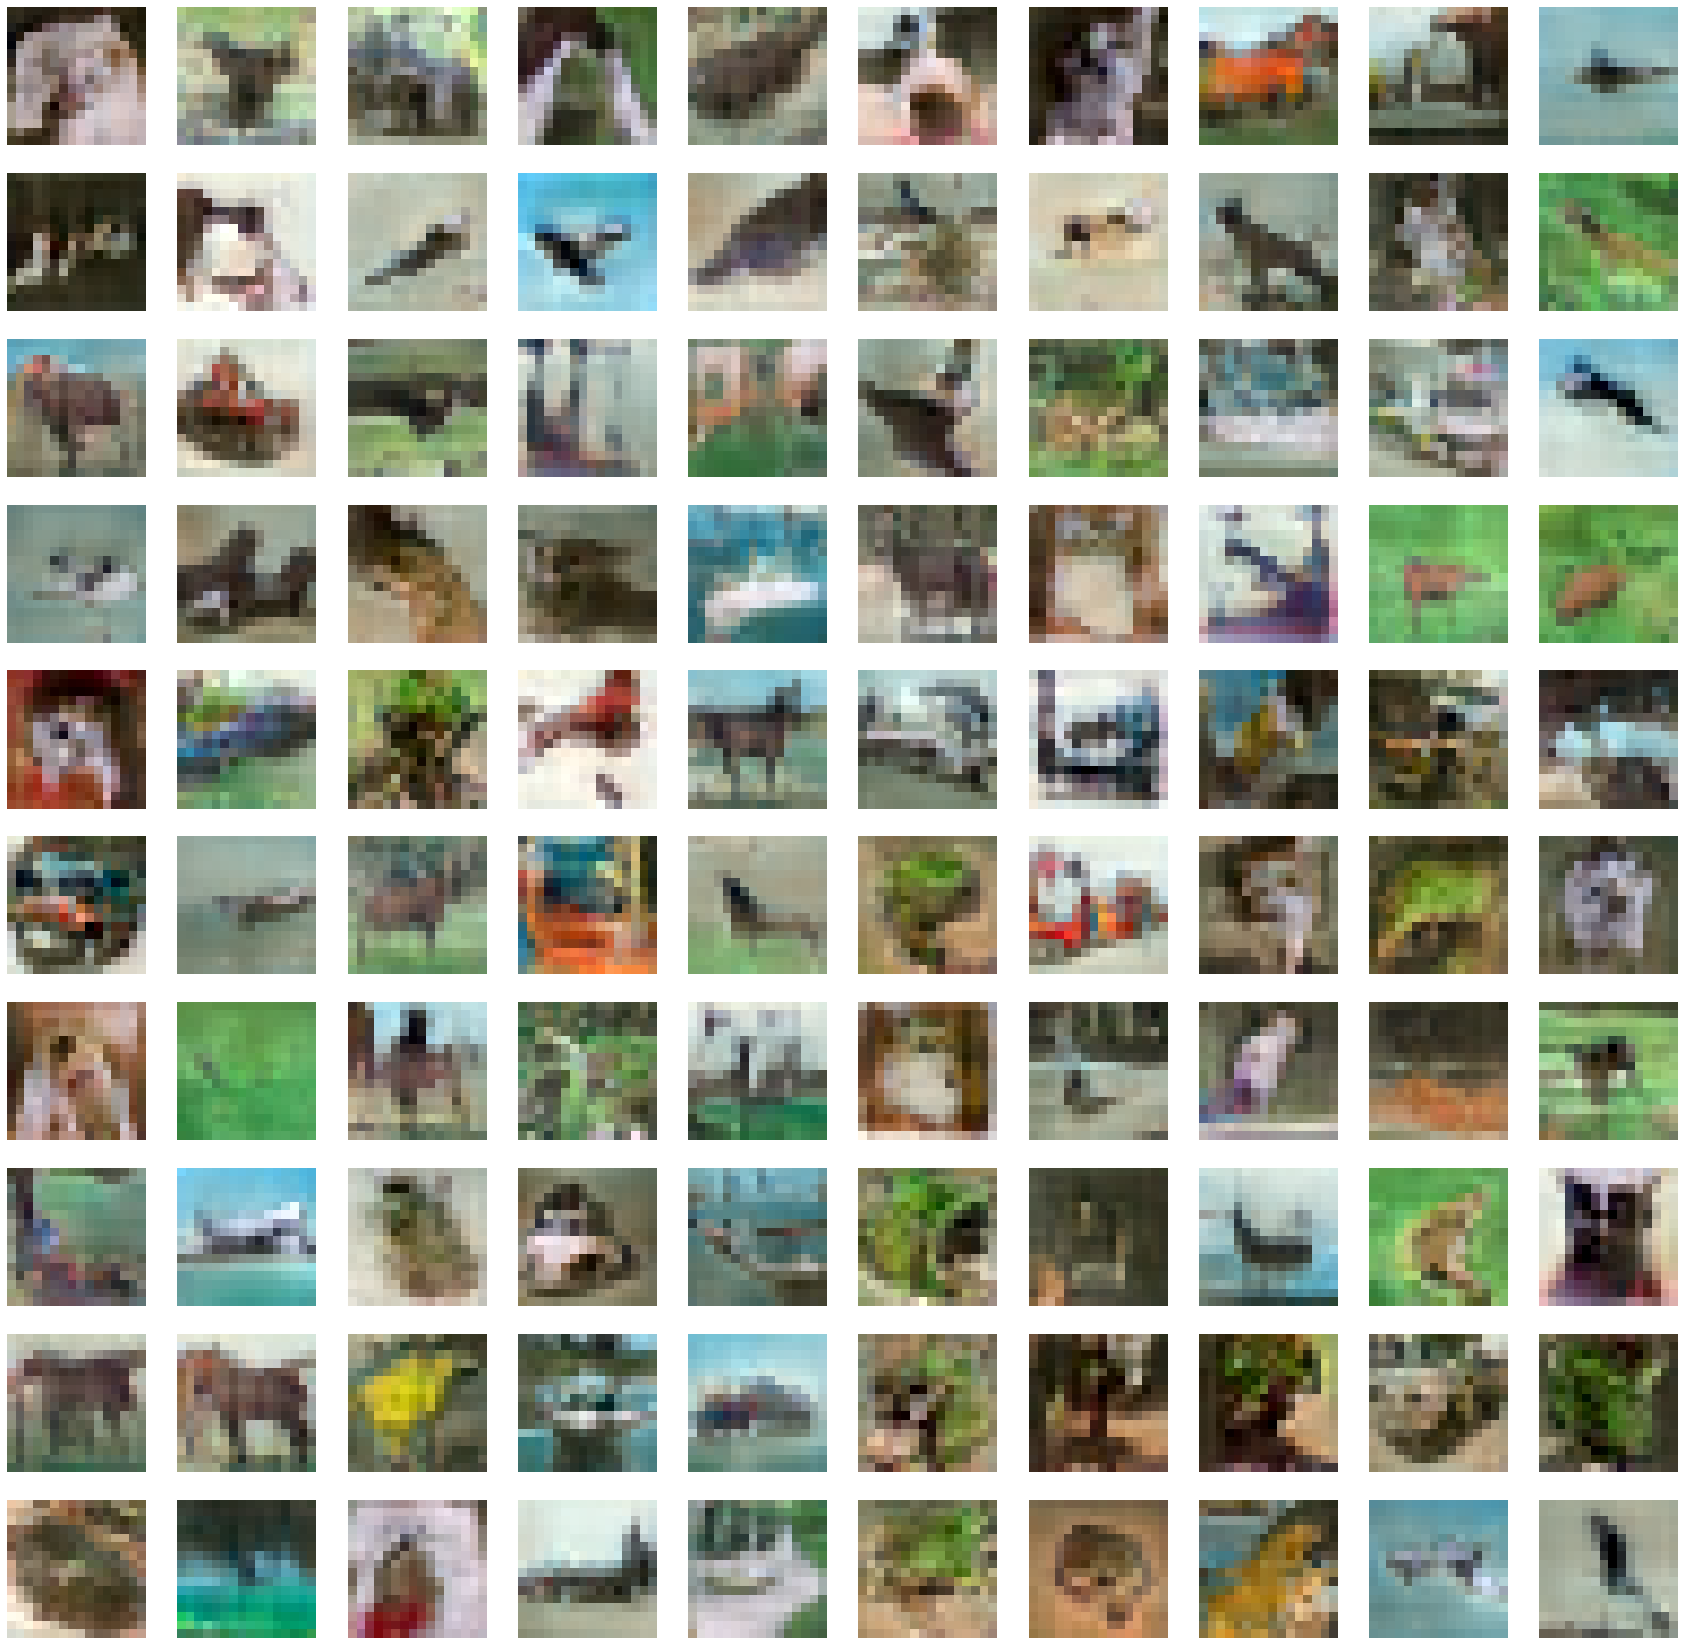

In [ ]:
random_vector = torch.empty((100,latent,1,1)).normal_(std=1).to(device)
im=generator(random_vector)
print(im.shape)
print(['máy bay','xe hơi','con chim','con mèo','con hươu','con chó','con ếch','ngựa','thuyền','xe tải'])
figure = plt.figure(figsize=(30, 30))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(im_reshape(de_scale(im[i-1].cpu().detach()),16).squeeze())
    #print(torch.max(im[i-1]), torch.min(im[i-1]))
plt.show()

# HUẤN LUYỆN MODEL $32\times 32$

In [ ]:
size=32
batch_size=16
epochs=48
latent=256

learning_rate=0.001
n_critics=1
n_student=1

tau=10
epsilon=750
drift=0.001

generator.adjust_list(layer_list_gen[:3])
discriminator.adjust_list(layer_list_dis[-3:])
generator=generator.to(device)
discriminator=discriminator.to(device)
dis_optimizer=torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_optimizer=torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_checkpoint,dis_checkpoint=load_model(16,generator,discriminator,gen_optimizer,dis_optimizer)

Done
Done


In [ ]:
generator.adjust_list(layer_list_gen[:4])
discriminator.adjust_list(layer_list_dis[-4:])
layer4_gen.set_a(0.1)
layer3_gen.set_a(1.)
layer2_gen.set_a(1.)
layer3_dis.set_a(0.1)
layer2_dis.set_a(1.)
layer1_dis.set_a(1.)
dis_optimizer=torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_optimizer=torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.,0.99))
jump_dict = {}
jumps = torch.linspace(0,1,16).to(device)
print(jumps.shape)
for i,jump in enumerate(jumps):
    jump_dict[str(i)] = jump
for i in range(16,epochs):
    jump_dict[str(i)] = torch.as_tensor(1).to(device)
print(len(jump_dict))
print(jump_dict)

Done
Done
Done
Done
Done
Done
Done
Done
torch.Size([16])
48
{'0': tensor(0., device='cuda:0'), '1': tensor(0.0667, device='cuda:0'), '2': tensor(0.1333, device='cuda:0'), '3': tensor(0.2000, device='cuda:0'), '4': tensor(0.2667, device='cuda:0'), '5': tensor(0.3333, device='cuda:0'), '6': tensor(0.4000, device='cuda:0'), '7': tensor(0.4667, device='cuda:0'), '8': tensor(0.5333, device='cuda:0'), '9': tensor(0.6000, device='cuda:0'), '10': tensor(0.6667, device='cuda:0'), '11': tensor(0.7333, device='cuda:0'), '12': tensor(0.8000, device='cuda:0'), '13': tensor(0.8667, device='cuda:0'), '14': tensor(0.9333, device='cuda:0'), '15': tensor(1., device='cuda:0'), '16': tensor(1, device='cuda:0'), '17': tensor(1, device='cuda:0'), '18': tensor(1, device='cuda:0'), '19': tensor(1, device='cuda:0'), '20': tensor(1, device='cuda:0'), '21': tensor(1, device='cuda:0'), '22': tensor(1, device='cuda:0'), '23': tensor(1, device='cuda:0'), '24': tensor(1, device='cuda:0'), '25': tensor(1, device='cud

In [ ]:
data=DataLoader(training_data_32,batch_size=batch_size,shuffle=True)

In [ ]:
generator_history,discriminator_history = init_state()

In [ ]:
for epoch in range(epochs):
    tim = t.time()
    
    layer4_gen.set_a(jump_dict[str(epoch)])
    layer3_dis.set_a(jump_dict[str(epoch)])

    for itter ,(X,Y) in enumerate(data):
        X = X.to(device) 
        batch_size=len(X)
        
        #HUAN LUYEN DISCRIMINATOR
        dis_optimizer.zero_grad()
        
        #get a batch of random tensor and fake data
        random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
        lambda_v = torch.rand((batch_size, 1, 1, 1)).to(device)
        fake_data = generator(random_vector)
        X.requires_grad = True
        meta = lambda_v*X + (1-lambda_v)*fake_data
        output = discriminator(meta)

        #gradient penalty
        norm=get_grad_norm(output,meta,epsilon)
        
        #train on REAL data
        real_discriminator_score = discriminator(X)
        
        #train on FAKE data
        fake_discriminator_score = discriminator(fake_data)
        
        #calculate loss
        
        fake_dis_loss , real_dis_loss = w_loss_dis(fake_discriminator_score,real_discriminator_score)
        sum_dis_loss = (fake_dis_loss - real_dis_loss
                        + tau*norm + (fake_dis_loss**2 + real_dis_loss**2)*drift )/(float(n_critics))

        #back-propagation
        sum_dis_loss.backward()
        dis_optimizer.step()
        
        #HUAN LUYEN GENERATOR
        if itter % n_critics == 0:
            for n in range(n_student):
                gen_optimizer.zero_grad()
                
                #get a batch of random tensor and fake data
                random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
            
                #get discriminator output
                discriminator_score_gen = discriminator(generator(random_vector))
                
                #calculate loss
                gen_loss = - w_loss_gen(discriminator_score_gen)/float(n_student)
                
                #back propagation
                gen_loss.backward()
                gen_optimizer.step()
        
        #LUU CAC THONG SO NOI
        generator_history['generator_loss'].append(gen_loss.item())
        discriminator_history['sum_discriminator_loss'].append(sum_dis_loss.item())
        discriminator_history['discriminator_loss'].append((real_dis_loss-fake_dis_loss).item())
        discriminator_history['discriminator_mean_score_on_both'].append((real_discriminator_score.mean().item()+fake_discriminator_score.mean().item())/2)
        discriminator_history['gradient norm'].append(norm.item())
        # HIEN THI THONG SO
        if (itter+1) % (len(data)//10) == 0:
            tim = t.time() - tim
            remain = ((epochs - epoch ) * 10 - ((itter+1) // (len(data)//10)) ) * tim
            print(f'[{epoch}/{epochs}][{itter}/{len(data)}]: {round(tim,2)}  remain {t.strftime("%H:%M:%S", t.gmtime(remain))}  Loss_D: {(real_dis_loss - fake_dis_loss).item()}  Loss_G: {gen_loss.item()}  norm: {norm.item()} ')
            tim = t.time()
    save_model(size)
    print('model saved')
    outp = make_grid(de_scale(generator(randim).squeeze().cpu().detach()),nrow=3)
    save_image(outp,f'/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/mnbstd_image/gen_size{size}_{epoch}.png')

Done
Done
[0/48][311/3125]: 16.9  remain 02:14:57  Loss_D: 733.0992431640625  Loss_G: 269.8885192871094  norm: 0.2021646648645401 
[0/48][623/3125]: 16.88  remain 02:14:29  Loss_D: 767.7334594726562  Loss_G: 643.8474731445312  norm: 0.21261058747768402 
[0/48][935/3125]: 16.88  remain 02:14:10  Loss_D: 518.592041015625  Loss_G: 86.02116394042969  norm: 0.38809388875961304 
[0/48][1247/3125]: 16.71  remain 02:12:34  Loss_D: 490.61590576171875  Loss_G: 393.90618896484375  norm: 0.35866260528564453 
[0/48][1559/3125]: 16.73  remain 02:12:26  Loss_D: 614.5703735351562  Loss_G: 145.35545349121094  norm: 0.24333378672599792 
[0/48][1871/3125]: 16.63  remain 02:11:23  Loss_D: 1016.0443115234375  Loss_G: 338.364501953125  norm: 0.4665512144565582 
[0/48][2183/3125]: 16.82  remain 02:12:37  Loss_D: 675.5667724609375  Loss_G: 379.2707824707031  norm: 0.3874945640563965 
[0/48][2495/3125]: 16.79  remain 02:12:05  Loss_D: 1117.0743408203125  Loss_G: 367.29498291015625  norm: 0.14432641863822937 
[

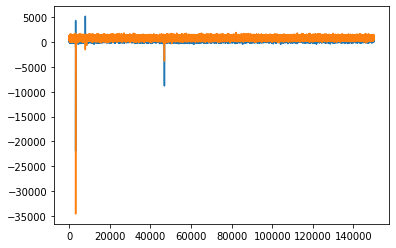

In [ ]:
plt.plot(generator_history['generator_loss'])
plt.plot(discriminator_history['discriminator_loss'])

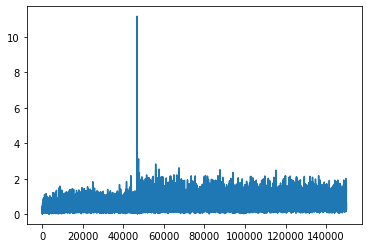

In [ ]:
plt.plot(discriminator_history['gradient norm'])

torch.Size([100, 3, 32, 32])
['máy bay', 'xe hơi', 'con chim', 'con mèo', 'con hươu', 'con chó', 'con ếch', 'ngựa', 'thuyền', 'xe tải']


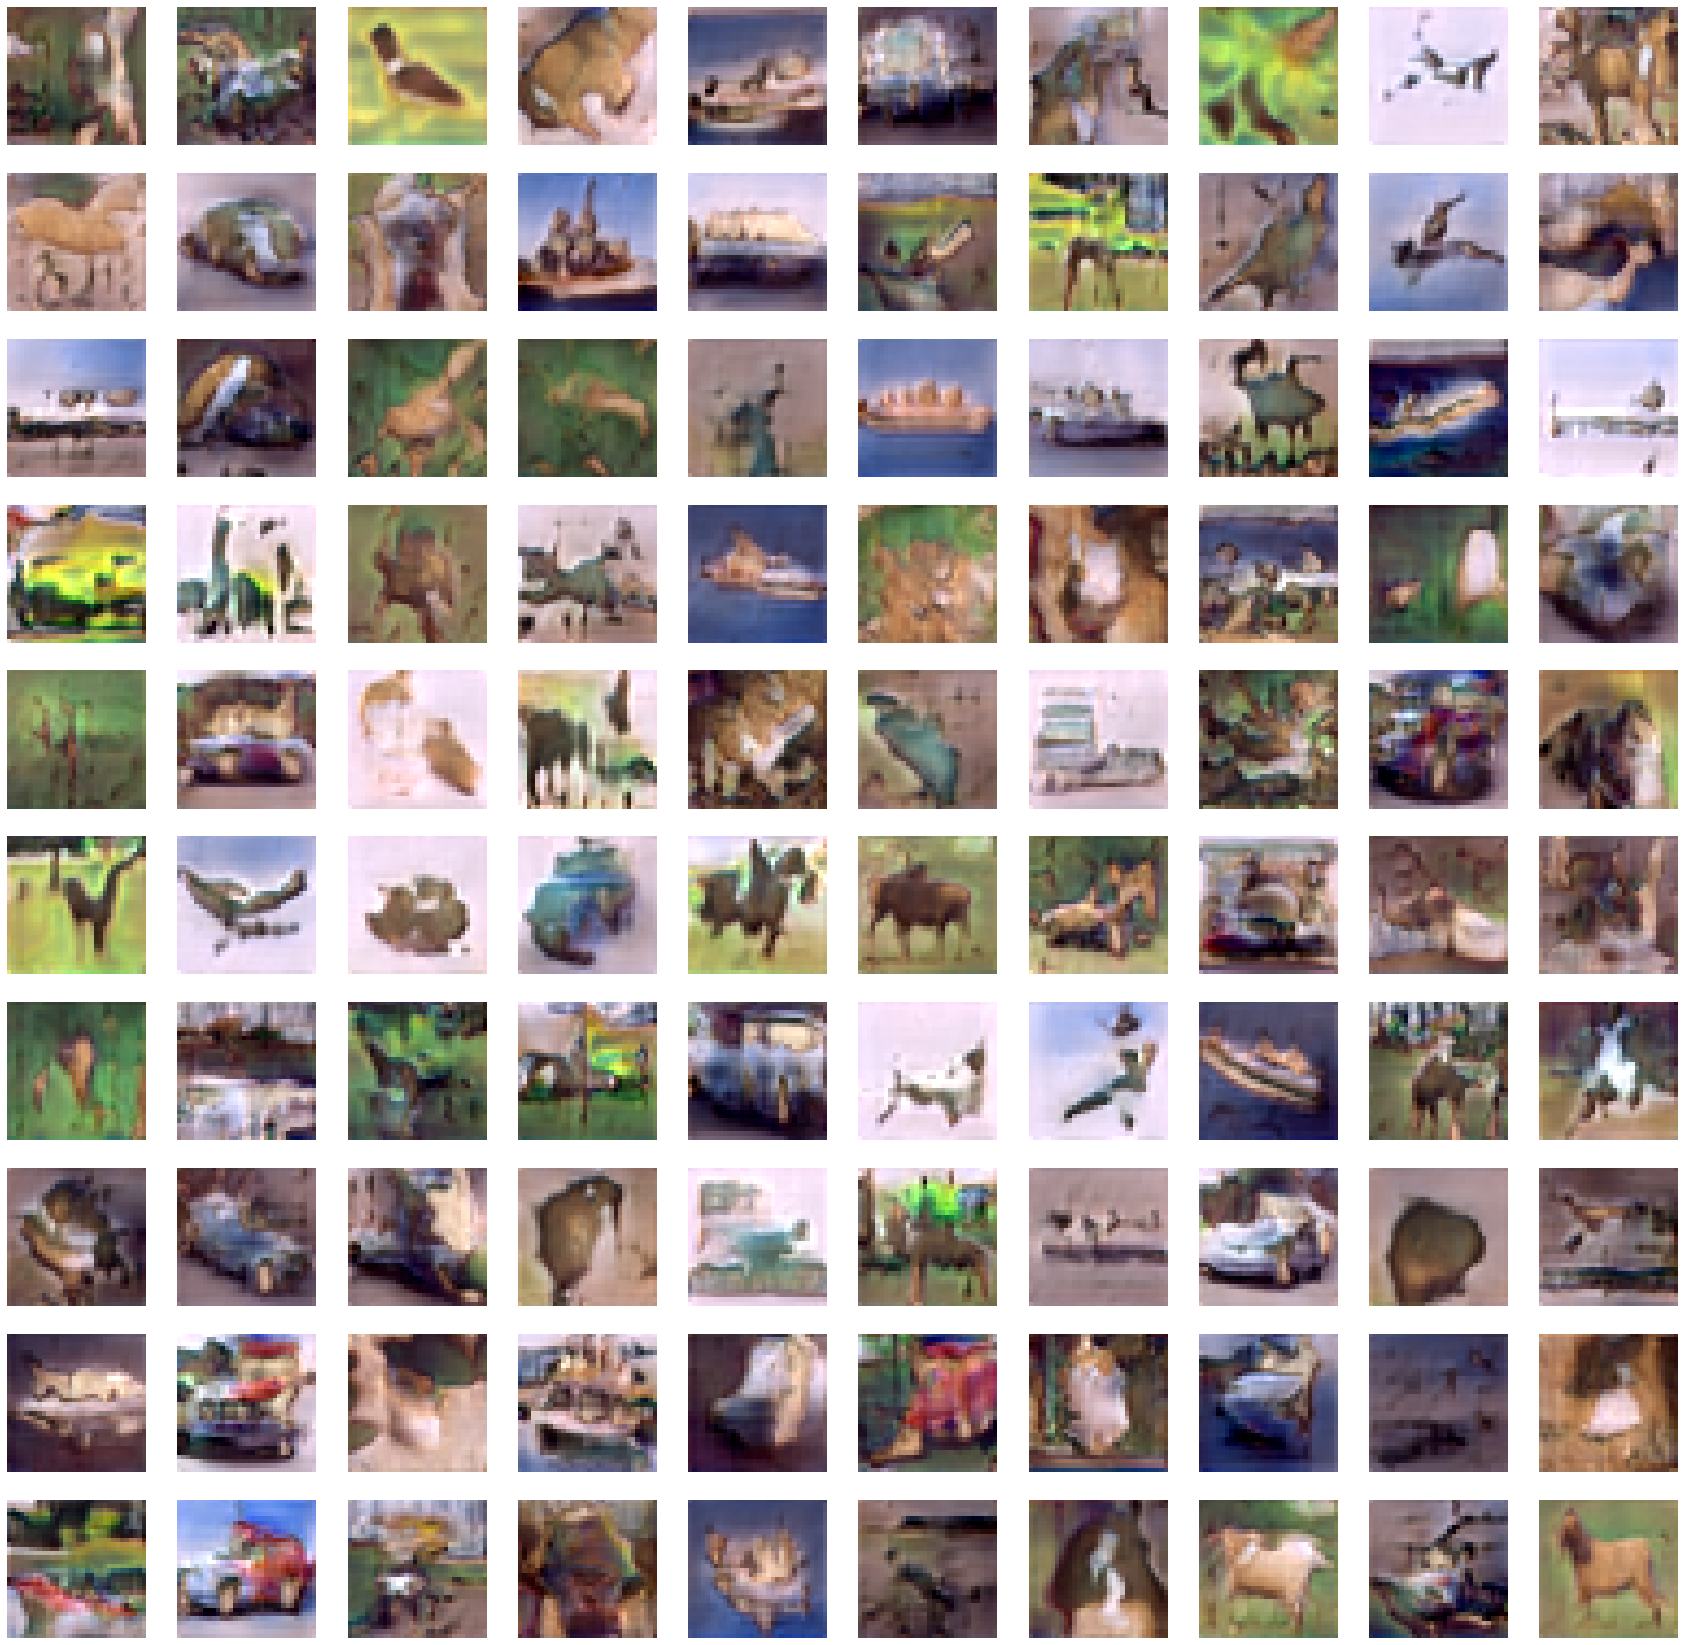

In [ ]:
random_vector = torch.empty((100,latent,1,1)).normal_(std=1).to(device)
im=generator(random_vector)
print(im.shape)
print(['máy bay','xe hơi','con chim','con mèo','con hươu','con chó','con ếch','ngựa','thuyền','xe tải'])
figure = plt.figure(figsize=(30, 30))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(im_reshape(torch.clip(de_scale(im[i-1].cpu().detach()),0,1),32).squeeze())
    #print(torch.max(im[i-1]), torch.min(im[i-1]))
plt.show()

In [ ]:
for epoch in range(epochs):
    tim = t.time()
    
    #layer4_gen.set_a(jump_dict[str(epoch)])
    #layer3_dis.set_a(jump_dict[str(epoch)])

    for itter ,(X,Y) in enumerate(data):
        X = X.to(device) 
        batch_size=len(X)
        
        #HUAN LUYEN DISCRIMINATOR
        dis_optimizer.zero_grad()
        
        #get a batch of random tensor and fake data
        random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
        lambda_v = torch.rand((batch_size, 1, 1, 1)).to(device)
        fake_data = generator(random_vector)
        X.requires_grad = True
        meta = lambda_v*X + (1-lambda_v)*fake_data
        output = discriminator(meta)

        #gradient penalty
        norm=get_grad_norm(output,meta,epsilon)
        
        #train on REAL data
        real_discriminator_score = discriminator(X)
        
        #train on FAKE data
        fake_discriminator_score = discriminator(fake_data)
        
        #calculate loss
        
        fake_dis_loss , real_dis_loss = w_loss_dis(fake_discriminator_score,real_discriminator_score)
        sum_dis_loss = (fake_dis_loss - real_dis_loss
                        + tau*norm + (fake_dis_loss**2 + real_dis_loss**2)*drift )/(float(n_critics))

        #back-propagation
        sum_dis_loss.backward()
        dis_optimizer.step()
        
        #HUAN LUYEN GENERATOR
        if itter % n_critics == 0:
            for n in range(n_student):
                gen_optimizer.zero_grad()
                
                #get a batch of random tensor and fake data
                random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
            
                #get discriminator output
                discriminator_score_gen = discriminator(generator(random_vector))
                
                #calculate loss
                gen_loss = - w_loss_gen(discriminator_score_gen)/float(n_student)
                
                #back propagation
                gen_loss.backward()
                gen_optimizer.step()
        
        #LUU CAC THONG SO NOI
        generator_history['generator_loss'].append(gen_loss.item())
        discriminator_history['sum_discriminator_loss'].append(sum_dis_loss.item())
        discriminator_history['discriminator_loss'].append((real_dis_loss-fake_dis_loss).item())
        discriminator_history['discriminator_mean_score_on_both'].append((real_discriminator_score.mean().item()+fake_discriminator_score.mean().item())/2)
        discriminator_history['gradient norm'].append(norm.item())
        # HIEN THI THONG SO
        if (itter+1) % (len(data)//10) == 0:
            tim = t.time() - tim
            remain = ((epochs - epoch ) * 10 - ((itter+1) // (len(data)//10)) ) * tim
            print(f'[{epoch}/{epochs}][{itter}/{len(data)}]: {round(tim,2)}  remain {t.strftime("%H:%M:%S", t.gmtime(remain))}  Loss_D: {(real_dis_loss - fake_dis_loss).item()}  Loss_G: {gen_loss.item()}  norm: {norm.item()} ')
            tim = t.time()
    save_model(size)
    print('model saved')
    outp = make_grid(de_scale(generator(randim).squeeze().cpu().detach()),nrow=3)
    save_image(outp,f'/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/mnbstd_image/gen_size{size}_{epochs+epoch}.png')

[0/48][311/3125]: 17.25  remain 02:17:44  Loss_D: 552.6109619140625  Loss_G: 726.6469116210938  norm: 1.3182826042175293 
[0/48][623/3125]: 16.8  remain 02:13:49  Loss_D: 650.3466796875  Loss_G: 584.1259155273438  norm: 1.1419689655303955 
[0/48][935/3125]: 16.63  remain 02:12:11  Loss_D: 1140.4229736328125  Loss_G: 72.19163513183594  norm: 0.7090930938720703 
[0/48][1247/3125]: 16.74  remain 02:12:46  Loss_D: 694.9331665039062  Loss_G: 450.2235107421875  norm: 0.7711723446846008 
[0/48][1559/3125]: 16.89  remain 02:13:44  Loss_D: 794.9956665039062  Loss_G: 647.32568359375  norm: 0.8540273904800415 
[0/48][1871/3125]: 16.96  remain 02:13:57  Loss_D: 1247.090576171875  Loss_G: 613.1207275390625  norm: 0.6109323501586914 
[0/48][2183/3125]: 16.8  remain 02:12:27  Loss_D: 1317.958251953125  Loss_G: 665.5467529296875  norm: 0.5040363669395447 
[0/48][2495/3125]: 16.69  remain 02:11:17  Loss_D: 544.4080810546875  Loss_G: 716.18212890625  norm: 0.6292163133621216 
[0/48][2807/3125]: 16.85  r

torch.Size([100, 3, 32, 32])
['máy bay', 'xe hơi', 'con chim', 'con mèo', 'con hươu', 'con chó', 'con ếch', 'ngựa', 'thuyền', 'xe tải']


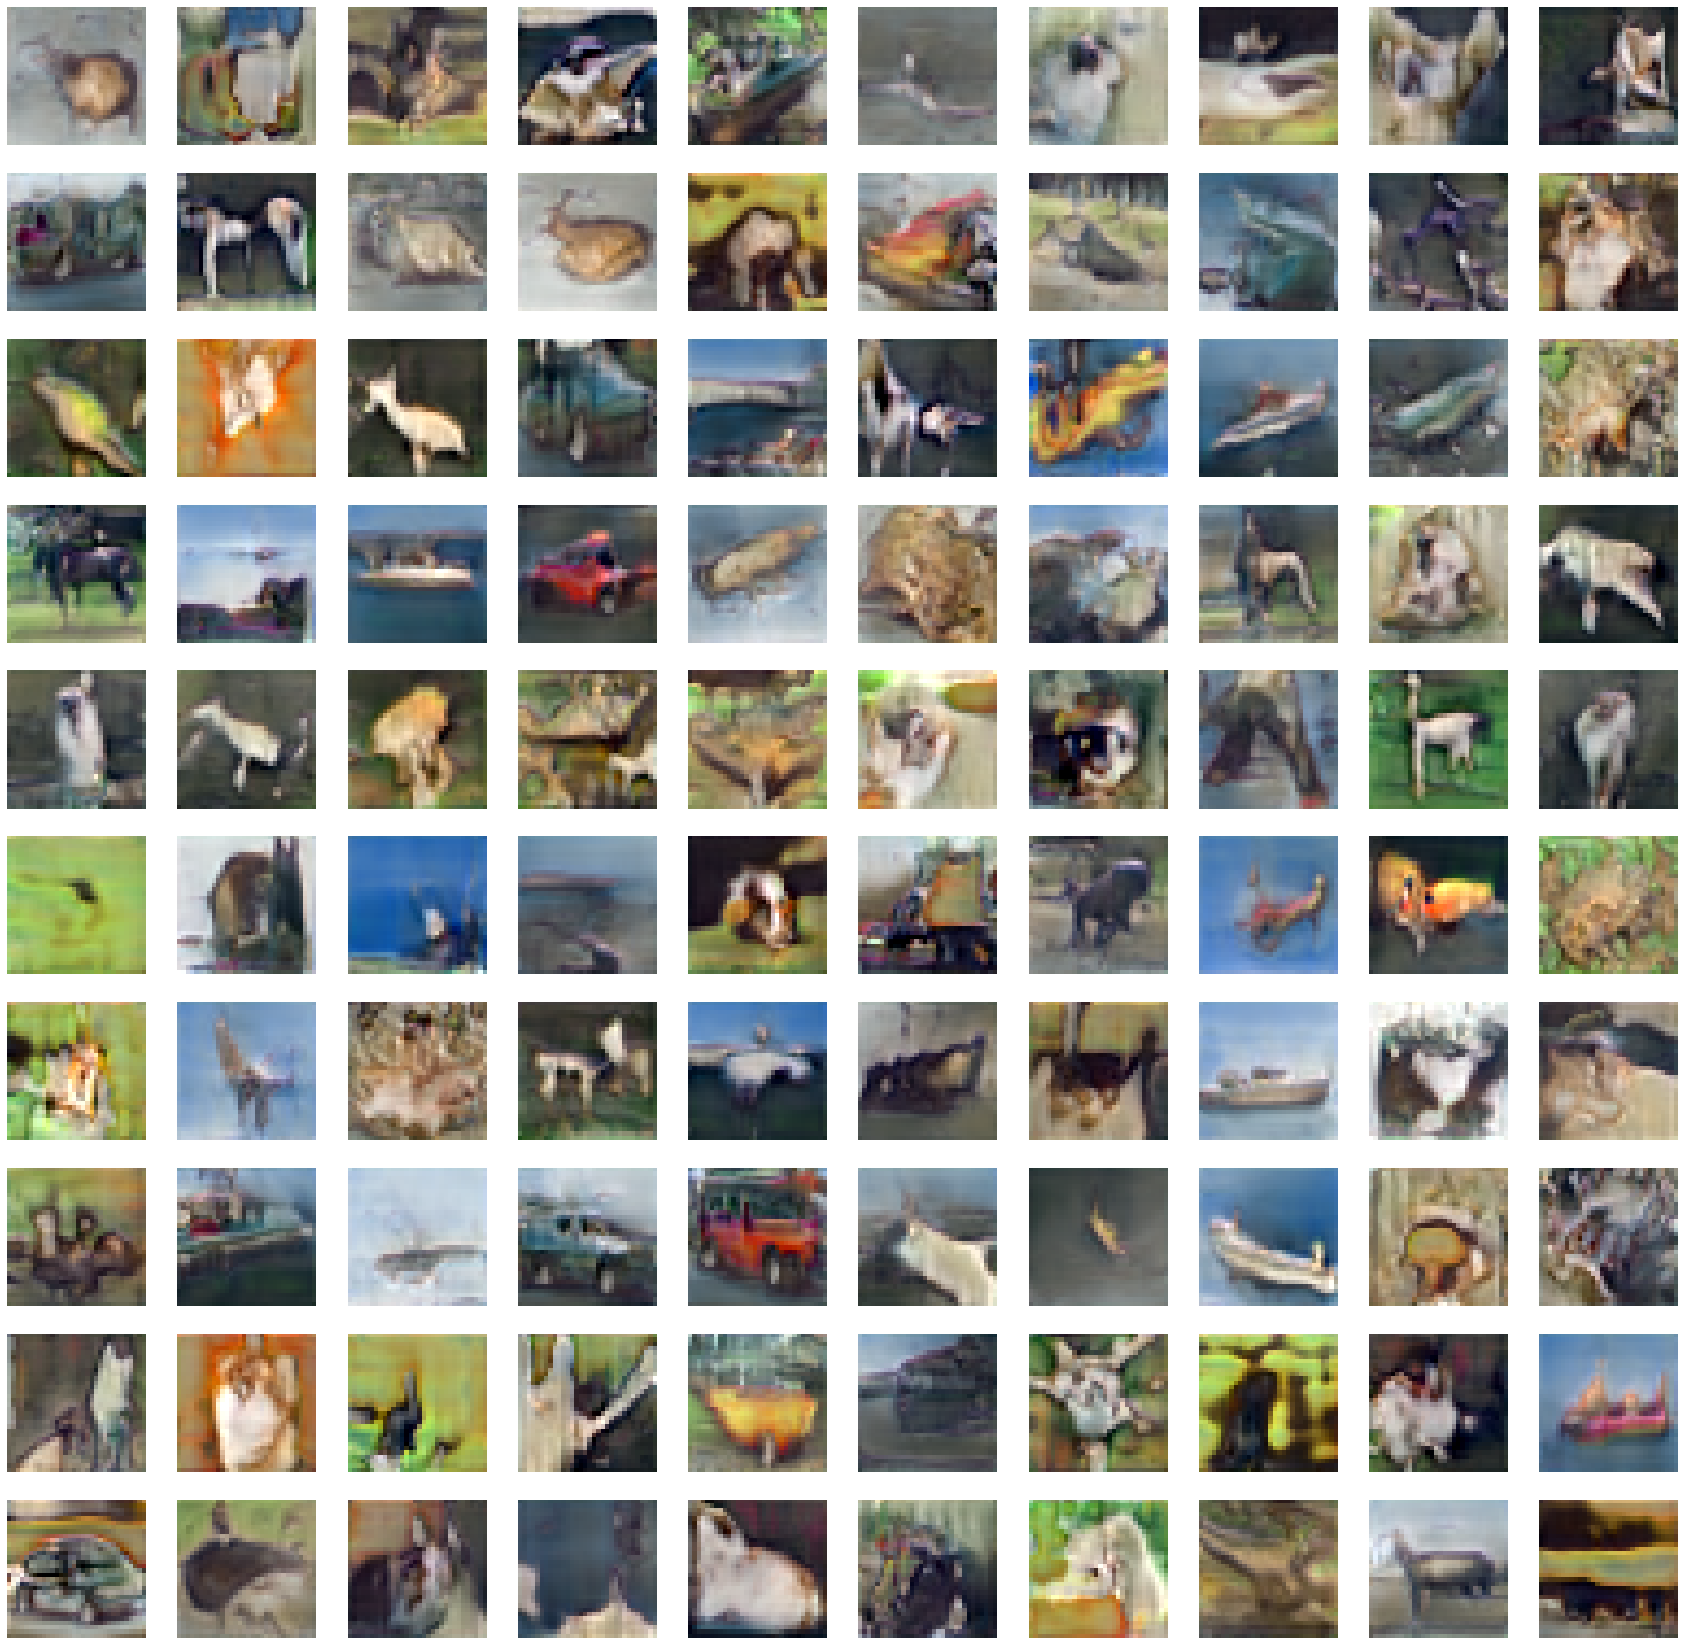

In [ ]:
random_vector = torch.empty((100,latent,1,1)).normal_(std=1).to(device)
im=generator(random_vector)
print(im.shape)
print(['máy bay','xe hơi','con chim','con mèo','con hươu','con chó','con ếch','ngựa','thuyền','xe tải'])
figure = plt.figure(figsize=(30, 30))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(im_reshape(torch.clip(de_scale(im[i-1].cpu().detach()),0,1),32).squeeze())
    #print(torch.max(im[i-1]), torch.min(im[i-1]))
plt.show()

torch.Size([100, 3, 32, 32])
['máy bay', 'xe hơi', 'con chim', 'con mèo', 'con hươu', 'con chó', 'con ếch', 'ngựa', 'thuyền', 'xe tải']


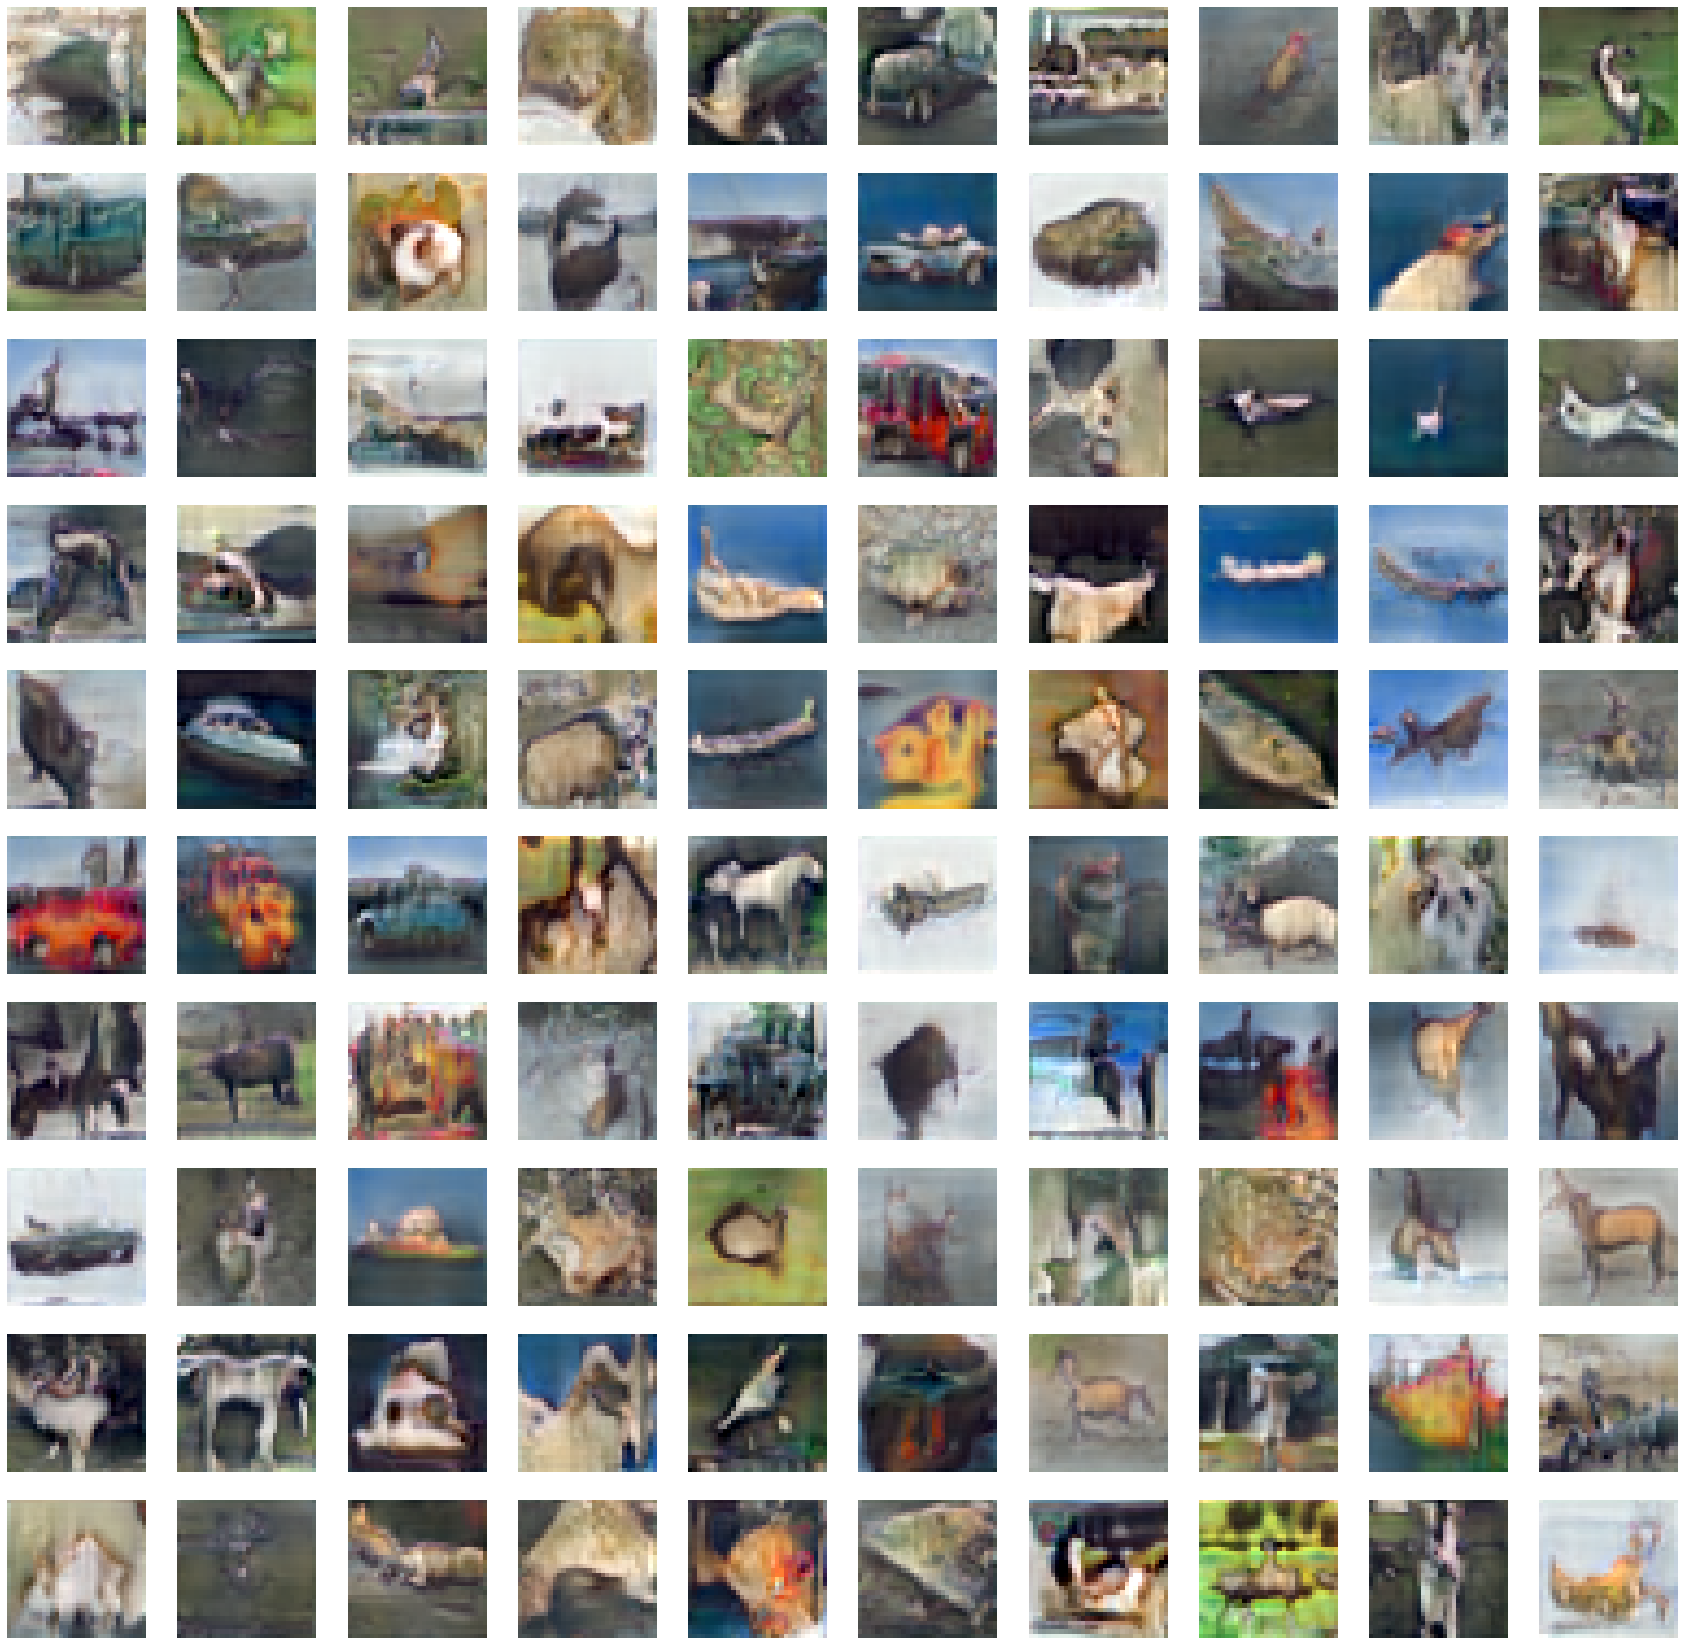

In [ ]:
random_vector = torch.empty((100,latent,1,1)).normal_(std=1).to(device)
im=generator(random_vector)
print(im.shape)
print(['máy bay','xe hơi','con chim','con mèo','con hươu','con chó','con ếch','ngựa','thuyền','xe tải'])
figure = plt.figure(figsize=(30, 30))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(im_reshape(torch.clip(de_scale(im[i-1].cpu().detach()),0,1),32).squeeze())
    #print(torch.max(im[i-1]), torch.min(im[i-1]))
plt.show()

# Tiếp tục train với Inception score

In [ ]:
size=32
batch_size=16
epochs=48
latent=256

learning_rate=0.001
n_critics=1
n_student=1

tau=10
epsilon=750
drift=0.001

generator.adjust_list(layer_list_gen[:])
discriminator.adjust_list(layer_list_dis[:])
generator=generator.to(device)
discriminator=discriminator.to(device)
dis_optimizer=torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_optimizer=torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(0.,0.99))
gen_checkpoint,dis_checkpoint=load_model(32,generator,discriminator,gen_optimizer,dis_optimizer)
incep=InceptionScore(device=device)

Done
Done


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
layer4_gen.set_a(1.)
layer3_gen.set_a(1.)
layer2_gen.set_a(1.)
layer3_dis.set_a(1.)
layer2_dis.set_a(1.)
layer1_dis.set_a(1.)

Done
Done
Done
Done
Done
Done


In [ ]:
data=DataLoader(training_data_32,batch_size=batch_size,shuffle=True)

In [ ]:
generator_history = gen_checkpoint['loss']
discriminator_history = dis_checkpoint['loss']
Incep_score = []

In [ ]:
for epoch in range(epochs):
    tim = t.time()
    
    for itter ,(X,Y) in enumerate(data):
        X = X.to(device)  
        batch_size=len(X)
        
        #HUAN LUYEN DISCRIMINATOR
        dis_optimizer.zero_grad()
        
        #get a batch of random tensor and fake data
        random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
        lambda_v = torch.rand((batch_size, 1, 1, 1)).to(device)
        fake_data = generator(random_vector)
        X.requires_grad = True
        meta = lambda_v*X + (1-lambda_v)*fake_data
        output = discriminator(meta)

        #gradient penalty
        norm=get_grad_norm(output,meta,epsilon)
        
        #train on REAL data
        real_discriminator_score = discriminator(X)
        
        #train on FAKE data
        fake_discriminator_score = discriminator(fake_data)
        
        #calculate loss
        
        fake_dis_loss , real_dis_loss = w_loss_dis(fake_discriminator_score,real_discriminator_score)
        sum_dis_loss = (fake_dis_loss - real_dis_loss 
                        + tau*norm + ( real_dis_loss**2) *drift )/(float(n_critics))

        #back-propagation
        sum_dis_loss.backward()
        dis_optimizer.step()
        
        #HUAN LUYEN GENERATOR
        if itter % n_critics == 0:
            for n in range(n_student):
                gen_optimizer.zero_grad()
                
                #get a batch of random tensor and fake data
                random_vector = torch.empty((batch_size,latent,1,1)).normal_().to(device)
            
                #get discriminator output
                discriminator_score_gen = discriminator(generator(random_vector))
                
                #calculate loss
                gen_loss = - w_loss_gen(discriminator_score_gen)/float(n_student)
                
                #back propagation
                gen_loss.backward()
                gen_optimizer.step()

        #LUU CAC THONG SO NOI
        generator_history['generator_loss'].append(gen_loss.item())
        discriminator_history['sum_discriminator_loss'].append(sum_dis_loss.item())
        discriminator_history['discriminator_loss'].append((real_dis_loss-fake_dis_loss).item())
        discriminator_history['discriminator_mean_score_on_both'].append((real_discriminator_score.mean().item()+fake_discriminator_score.mean().item())/2)
        discriminator_history['gradient norm'].append(norm.item())

        # HIEN THI THONG SO
        if (itter+1) % (len(data)//10) == 0:
            tim = t.time() - tim
            remain = ((epochs - epoch ) * 10 - ((itter+1) // (len(data)//10)) ) * tim
            print(f'[{epoch}/{epochs}][{itter}/{len(data)}]: {round(tim,2)}  remain {t.strftime("%H:%M:%S", t.gmtime(remain))}  Loss_D: {(real_dis_loss - fake_dis_loss).item()}  Loss_G: {gen_loss.item()}  norm: {norm.item()} ')
            tim = t.time()
    
    #TINH INCEPTION SCORE
    incep.update(interpolate(fake_data))
    Incep_Score.append(incep.compute())
    
    save_model(size)
    print(f'model saved, InceptionScore: {Incep_Score[-1]}')
    outp = make_grid(de_scale(generator(randim).squeeze().cpu().detach()),nrow=3)
    save_image(outp,f'/content/drive/MyDrive/Colab Notebooks/GAN /progressive_gan/mnbstd_image/gen_size{size}_{epoch}.png')

[0/48][311/3125]: 17.41  remain 02:18:59  Loss_D: 3938.270263671875  Loss_G: 4951.3857421875  norm: 77.99032592773438 
[0/48][623/3125]: 16.4  remain 02:10:40  Loss_D: 1663.072509765625  Loss_G: 5319.42724609375  norm: 151.21893310546875 
[0/48][935/3125]: 16.53  remain 02:11:24  Loss_D: 6326.5361328125  Loss_G: 6714.3310546875  norm: 154.62567138671875 
[0/48][1247/3125]: 17.63  remain 02:19:53  Loss_D: 7589.0810546875  Loss_G: 11706.2080078125  norm: 195.3684539794922 
[0/48][1559/3125]: 16.72  remain 02:12:20  Loss_D: 12582.0224609375  Loss_G: 14066.0966796875  norm: 173.23068237304688 
[0/48][1871/3125]: 16.46  remain 02:09:59  Loss_D: 6582.3291015625  Loss_G: 7779.6904296875  norm: 121.56352233886719 
[0/48][2183/3125]: 16.81  remain 02:12:30  Loss_D: 3176.2294921875  Loss_G: 2979.55078125  norm: 142.52719116210938 
[0/48][2495/3125]: 16.64  remain 02:10:56  Loss_D: 6473.728515625  Loss_G: 5010.197265625  norm: 107.9378662109375 
[0/48][2807/3125]: 16.41  remain 02:08:49  Loss_D: 

RuntimeError: ignored

In [ ]:
batch_size = 100
random_vector = torch.empty((50000,latent,1,1)).normal_(std=1).to(device)
data=DataLoader(random_vector,batch_size=batch_size,shuffle=True)
incep.reset()
for itter ,X in enumerate(data):
    fine_image = interpolate(generator(X))
    incep.update(fine_image)
    score=incep.compute()
    print(itter,score)
score=incep.compute()

KeyboardInterrupt: ignored

In [ ]:
print(score)

In [ ]:
random_vector = torch.empty((100,latent,1,1)).normal_(std=1).to(device)
im=generator(random_vector)
print(im.shape)
print(['máy bay','xe hơi','con chim','con mèo','con hươu','con chó','con ếch','ngựa','thuyền','xe tải'])
figure = plt.figure(figsize=(30, 30))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(im_reshape(interpolate(torch.clip(de_scale(im[i-1].cpu().detach()),0,1)),299).squeeze())
    #print(torch.max(im[i-1]), torch.min(im[i-1]))
plt.show()

In [ ]:
batch_size = 100
incep=InceptionScore()
transform=Compose([
                  #Resize(299),
                  ToTensor(),
                  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                  ])
training_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = transform
)
class IgnoreLabelDataset(torch.utils.data.Dataset):
    def __init__(self, orig):
        self.orig = orig

    def __getitem__(self, index):
        return self.orig[index][0]

    def __len__(self):
        return len(self.orig)
dataset = IgnoreLabelDataset(training_data)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified


In [ ]:
data=DataLoader(dataset,batch_size=batch_size,shuffle=True)
print(len(data))
incep.reset()
for itter ,X in enumerate(data):
    incep.update(interpolate(X))  
    print(itter)
score=incep.compute()

500


In [ ]:
print(score)

6.617074082099464


In [ ]:
from ignite.engine import Engine
from ignite.metrics.gan import InceptionScore
from ignite.contrib.handlers import ProgressBar
import torchvision.datasets as dset
import torchvision.transforms as transforms
import ignite.distributed as idist
import torch
class IgnoreLabelDataset(torch.utils.data.Dataset):
    def __init__(self, orig):
        self.orig = orig

    def __getitem__(self, index):
        return self.orig[index][0]

    def __len__(self):
        return len(self.orig)



cifar = dset.CIFAR10(root='data/', download=True,
                          transform=transforms.Compose([
                              transforms.Resize(299),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ])
)

def process_func(engine,batch):
  if batch.device != idist.device():
    batch = batch.to(idist.device())
  return batch

test_engine = Engine(process_func)
pbar = ProgressBar()
pbar.attach(test_engine)
dataset = IgnoreLabelDataset(cifar)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=32,shuffle=True)
inception_score = InceptionScore(device=idist.device())
inception_score.attach(test_engine,"score")
state = test_engine.run(dataloader)
print(state.metrics)

  0%|          | 0/170498071 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print(idist.device())

cuda
